<a href="https://colab.research.google.com/github/menciaveas/curso-python-us/blob/main/CasoPractico_TFG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering de series IPC por grupos ECOICOP
## Análisis por periodos

A continuación presentamos un caso práctico, ejemplo de la forma de proceder en el análisis de conglomerados con series temporales. Se utilizarán los datos del Índice de Precios de Consumo (IPC) desde 2002 hasta 2023. Se trata de hacer un análisis cluster de series temporales por grupos ECOICOP en varios periodos para ver la evolución de los conglomerados en el tiempo.

Los grupos ECOICOP son:

- Alimentos y bebidas no alcohólicas.
- Bebidas alcohólicas y tabaco.
- Vestido y calzado.
- Vivienda.
- Menaje.
- Medicina.
- Transporte.
- Comunicaciones.
- Ocio y cultura.
- Enseñanza.
- Hoteles, cafés y restaurantes.
- Otros bienes y servicios.


El clustering de series temporales está basado fundamentalmente en la definición de distancias entre series. Una vez definidas estas distancias, sólo hay que aplicar el algoritmos de análisis de conglomerados más conveniente.





## Importación de módulos

En primer lugar, se importan las librerías y los módulos principales que servirán a lo largo de toda la práctica. Más adelante, cuando sean necesarias funciones específicas de algún otro módulo, entonces se importarán. Así el proceso queda más claro.

In [1]:
!pip install datetime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 8.9 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

## Lectura y preparación de datos

A continuación, se lee la base de datos de las estadísticas IPC a la que se puede acceder a través de la página web del Instituto Nacional de Estadística ([https://ine.es/](https://ine.es/)).

Para hacer un estudio más exhaustivo y acertado, evitando el ruido que puede producir una serie temporal excesivamente larga en la que se observan diferentes comportammientos, vamos a dividir los datos en cuatro periodos:

Periodo 1: Enero 2002 a julio 2008 (antes de la crisis económica de la burbuja inmobiliaria).

Periodo 2: Agosto 2008 a febrero 2013 (la crisis económica).

Periodo 3: Marzo 2013 a febrero 2020 (el período de recuperación de esta crisis hasta que se decretó el estado de alarma por la pandemia).

Periodo 4: Marzo 2020 a agosto 2023 (periodo de estado de alarma hasta agosto de 2022).

Para una lectura correcta de las fechas, la función *read_excel* permite especificar los campos que tienen un formato, así como una función para procesar dicho tipo de dato.

In [63]:
# Función que transforma una cadena de formato "%YM%m", en una fecha
def f(string):
  d = datetime.datetime.strptime(string,"%YM%m").date()
  return(d)

In [64]:
file = 'IPC_database.xls'
periodos = pd.read_excel(io = file,sheet_name = 'Datos',header = 0,usecols="B") 

# Definición del conjunto de filas que hay que desechar en cada periodo
skipP1 = [i+1 for i in periodos.loc[periodos.iloc[:,0] != 1].index]
skipP2 = [i+1 for i in periodos.loc[periodos.iloc[:,0] != 2].index]
skipP3 = [i+1 for i in periodos.loc[periodos.iloc[:,0] != 3].index]
skipP4 = [i+1 for i in periodos.loc[periodos.iloc[:,0] != 4].index]

# Lectura los datos de cada periodo
datos_P1 = pd.read_excel(io = file,sheet_name = 'Datos',header = 0,usecols="A,C:N", parse_dates=["Fecha"], date_parser=f,skiprows=[i for i in skipP1])
datos_P2 = pd.read_excel(io = file,sheet_name = 'Datos',header = 0,usecols="A,C:N", parse_dates=["Fecha"], date_parser=f,skiprows=[i for i in skipP2])  
datos_P3 = pd.read_excel(io = file,sheet_name = 'Datos',header = 0,usecols="A,C:N", parse_dates=["Fecha"], date_parser=f,skiprows=[i for i in skipP3])  
datos_P4 = pd.read_excel(io = file,sheet_name = 'Datos',header = 0,usecols="A,C:N", parse_dates=["Fecha"], date_parser=f,skiprows=[i for i in skipP4])  

# Las fechas se declaran como el nombre de las filas 
datos_P1.rename(index=datos_P1["Fecha"],inplace=True)
datos_P1 = datos_P1.drop(['Fecha'], axis=1)
datos_P2.rename(index=datos_P2["Fecha"],inplace=True)
datos_P2 = datos_P2.drop(['Fecha'], axis=1)
datos_P3.rename(index=datos_P3["Fecha"],inplace=True)
datos_P3 = datos_P3.drop(['Fecha'], axis=1)
datos_P4.rename(index=datos_P4["Fecha"],inplace=True)
datos_P4 = datos_P4.drop(['Fecha'], axis=1)

In [65]:
# Lectura de los grupos ECOICOP, que están guardados en la base de datos
ECOICOP = pd.read_excel(io = file,sheet_name = 'Metadatos',header = 0,usecols="B")
ECOICOP = ECOICOP[2:19] # Se eliminan las repeticiones y los valores no observados
ECOICOP = [ecoicop[0] for ecoicop in ECOICOP.to_numpy()] # Se guarda en formato lista
ECOICOP

['Alimentos y bebidas no alcohólicas',
 'Bebidas alcohólicas y tabaco',
 'Vestido y calzado',
 'Vivienda, agua, electricidad, gas y otros combustibles',
 'Muebles, artículos del hogar y artículos para el mantenimiento corriente del hogar',
 'Sanidad',
 'Transporte',
 'Comunicaciones',
 'Ocio y cultura',
 'Enseñanza',
 'Restaurantes y hoteles',
 'Otros bienes y servicios ']

Es conveniente comprobar que todo avanza tal y como se ha previsto.

In [66]:
datos_P1.head()

IPC_01  IPC_02  IPC_03  IPC_04  IPC_05  IPC_06  IPC_07   IPC_08  \
2002-01-01  65.859  46.340  82.717  58.763  81.364  86.313  63.805  128.593   
2002-02-01  65.836  46.348  81.782  58.888  81.475  86.844  64.089  126.667   
2002-03-01  66.185  46.436  83.519  59.041  81.819  87.210  65.007  125.098   
2002-04-01  66.614  48.321  89.456  59.223  82.336  87.665  66.018  125.098   
2002-05-01  66.902  48.446  90.427  59.324  82.686  87.212  66.191  125.098   

             IPC_09  IPC_10  IPC_11  IPC_12  
2002-01-01  101.553  58.352  63.523  65.705  
2002-02-01  101.580  58.430  64.123  65.834  
2002-03-01  103.157  58.496  64.756  66.045  
2002-04-01  102.658  58.556  65.182  66.185  
2002-05-01  102.968  58.563  65.416  66.299

Además, se cargan las imágenes que identificarán a los grupos ECOICOP y se guardan en el formato conveniente.

In [67]:
from PIL import Image
i1 = Image.open("/content/apple.png")
i1.save("/content/apple.png")
i2 = Image.open("/content/beer.png")
i2.save("/content/beer.png")
i3 = Image.open("/content/chaqueta.png")
i3.save("/content/chaqueta.png")
i4 = Image.open("/content/house.png")
i4.save("/content/house.png")
i5 = Image.open("/content/closet.png")
i5.save("/content/closet.png")
i6 = Image.open("/content/medical.png")
i6.save("/content/medical.png")
i7 = Image.open("/content/car.png")
i7.save("/content/car.png")
i8 = Image.open("/content/antena.png")
i8.save("/content/antena.png")
i9 = Image.open("/content/basketball.png")
i9.save("/content/basketball.png")
i10 = Image.open("/content/books.png")
i10.save("/content/books.png")
i11 = Image.open("/content/chef.png")
i11.save("/content/chef.png")
i12 = Image.open("/content/suma.png")
i12.save("/content/suma.png")

## Representación gráfica de las series variacionales por periodo

Para proceder, es razonable tener una idea de la forma de las series temporales que forman parte del conjunto que se quiere particionar. 

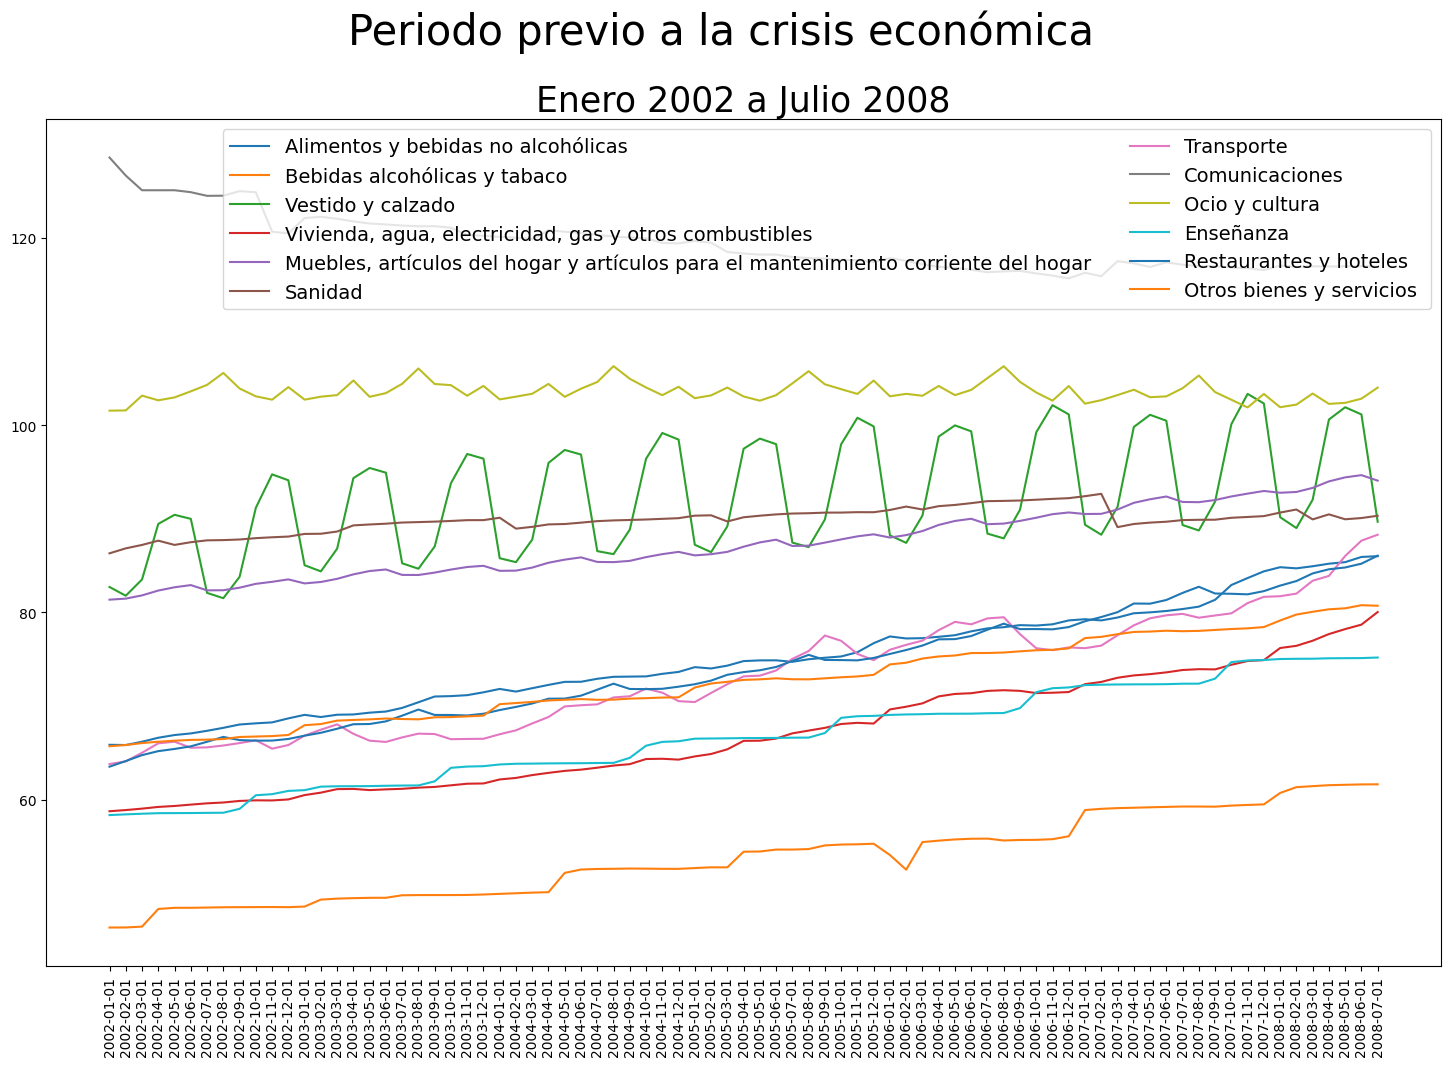

In [ ]:
plt.figure(figsize=(18,11))
x = range(0,datos_P1.shape[0])
labels = [d.date() for d in datos_P1.index]
plt.plot(x,datos_P1)
plt.legend(ECOICOP,fontsize = 14,ncol = 2)
plt.xticks(x, labels, rotation='vertical')
plt.title("Enero 2002 a Julio 2008",fontsize=25)
plt.suptitle("Periodo previo a la crisis económica",fontsize=30)
plt.show()

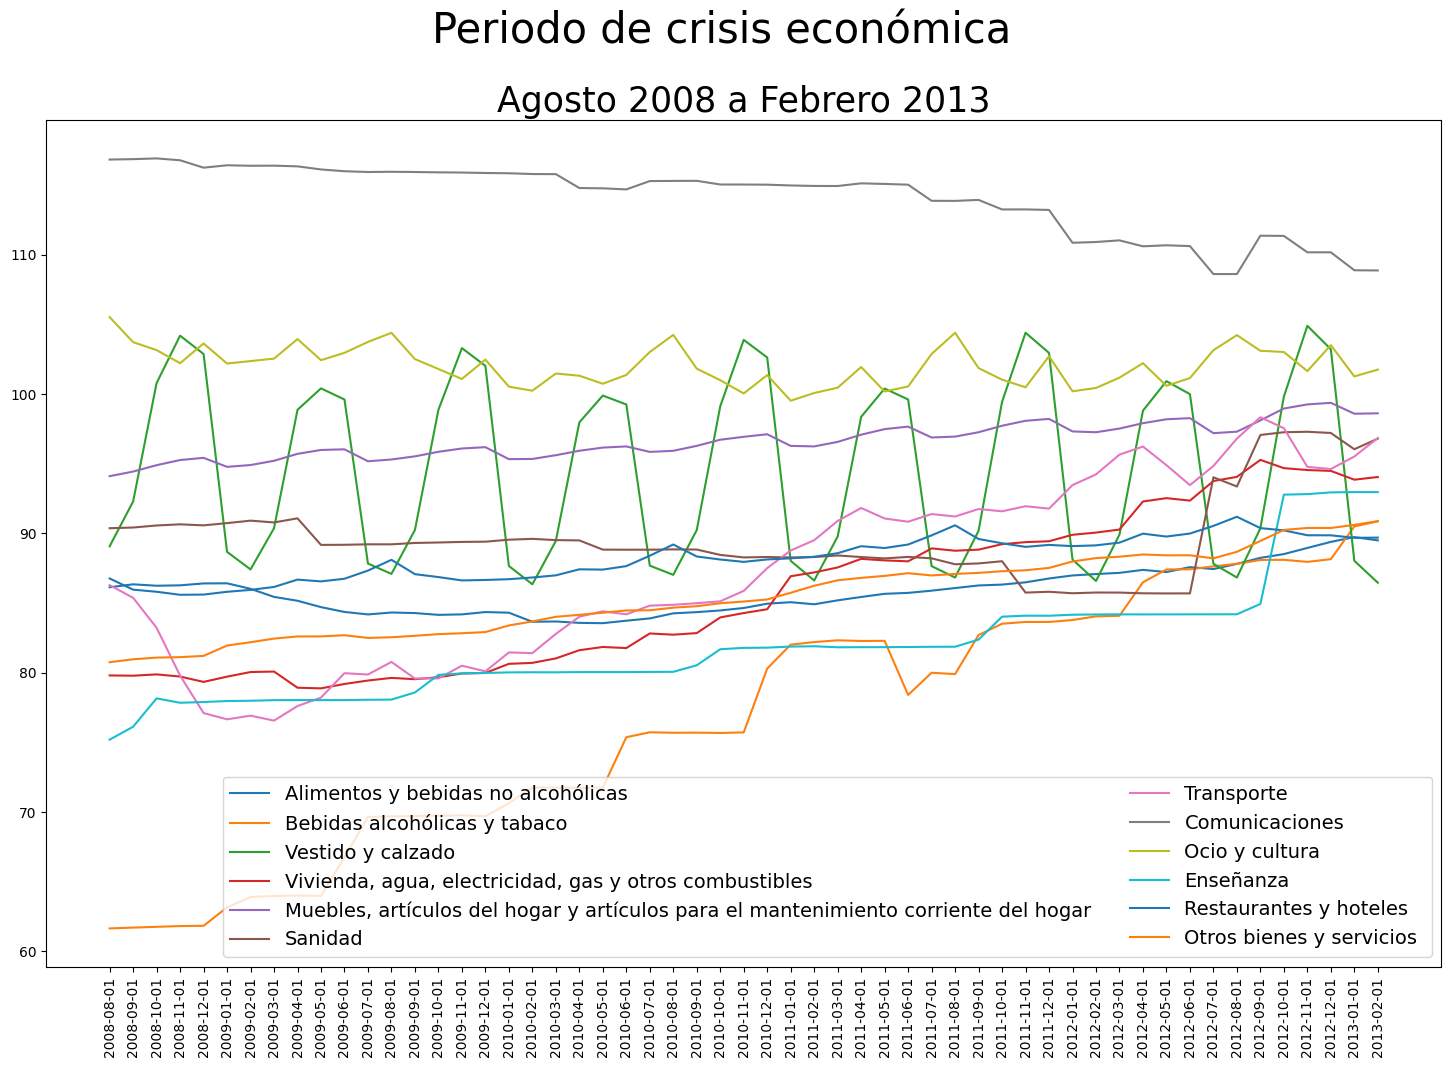

In [ ]:
plt.figure(figsize=(18,11))
x = range(0,datos_P2.shape[0])
labels = [d.date() for d in datos_P2.index]
plt.plot(x,datos_P2)
plt.legend(ECOICOP,fontsize = 14,ncol = 2)
plt.xticks(x, labels, rotation='vertical')
plt.title("Agosto 2008 a Febrero 2013",fontsize=25)
plt.suptitle("Periodo de crisis económica",fontsize=30)
plt.show()

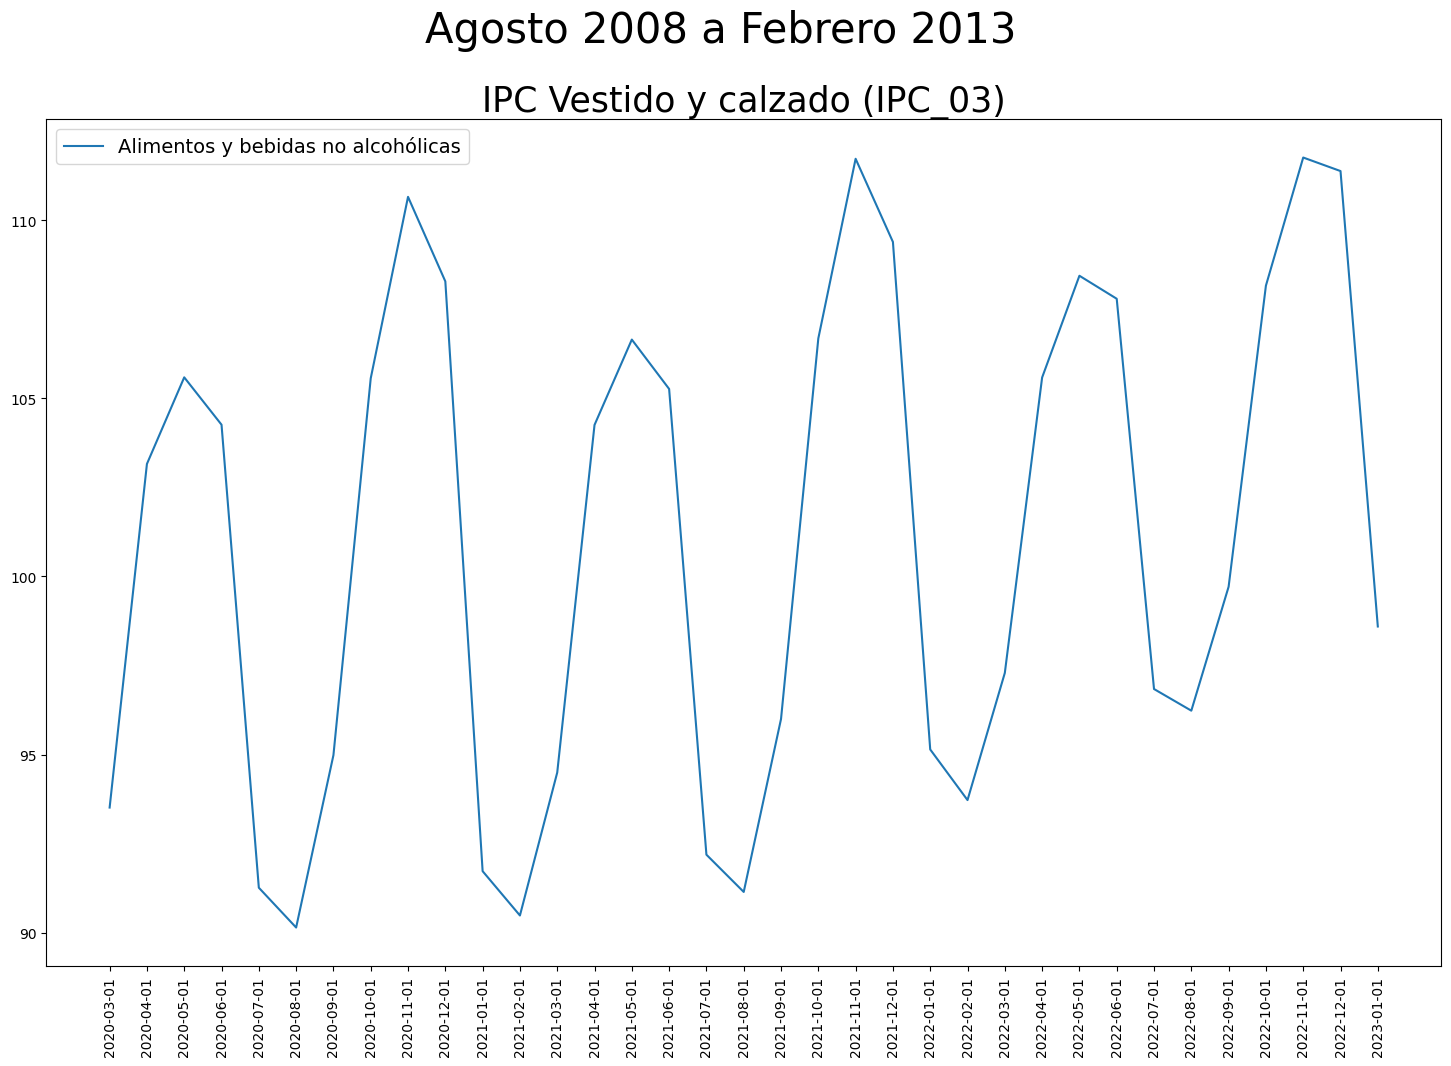

In [ ]:
plt.figure(figsize=(18,11))
x = range(0,datos_P4.shape[0])
labels = [d.date() for d in datos_P4.index]
plt.plot(x,datos_P4.iloc[:,2])
plt.legend(ECOICOP,fontsize = 14,ncol = 2)
plt.xticks(x, labels, rotation='vertical')
plt.title("IPC Vestido y calzado (IPC_03)",fontsize=25)
plt.suptitle("Agosto 2008 a Febrero 2013",fontsize=30)
plt.show()

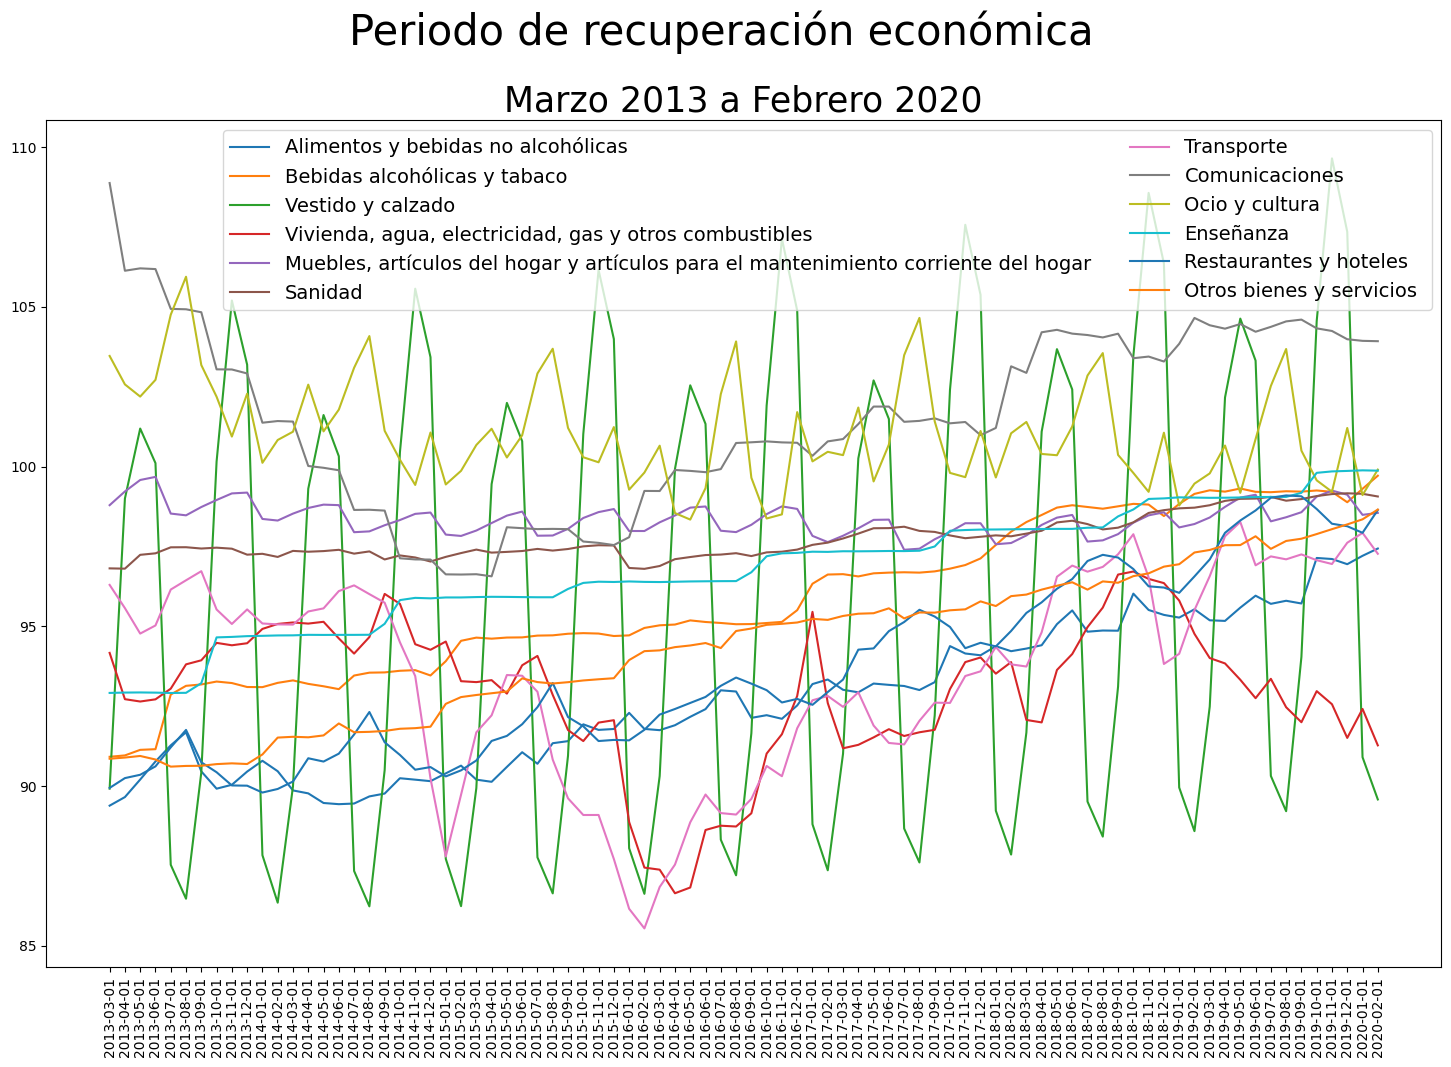

In [ ]:
plt.figure(figsize=(18,11))
x = range(0,datos_P3.shape[0])
labels = [d.date() for d in datos_P3.index]
plt.plot(x,datos_P3)
plt.legend(ECOICOP,fontsize = 14,ncol = 2)
plt.xticks(x, labels, rotation='vertical')
plt.title("Marzo 2013 a Febrero 2020",fontsize=25)
plt.suptitle("Periodo de recuperación económica",fontsize=30)
plt.show()

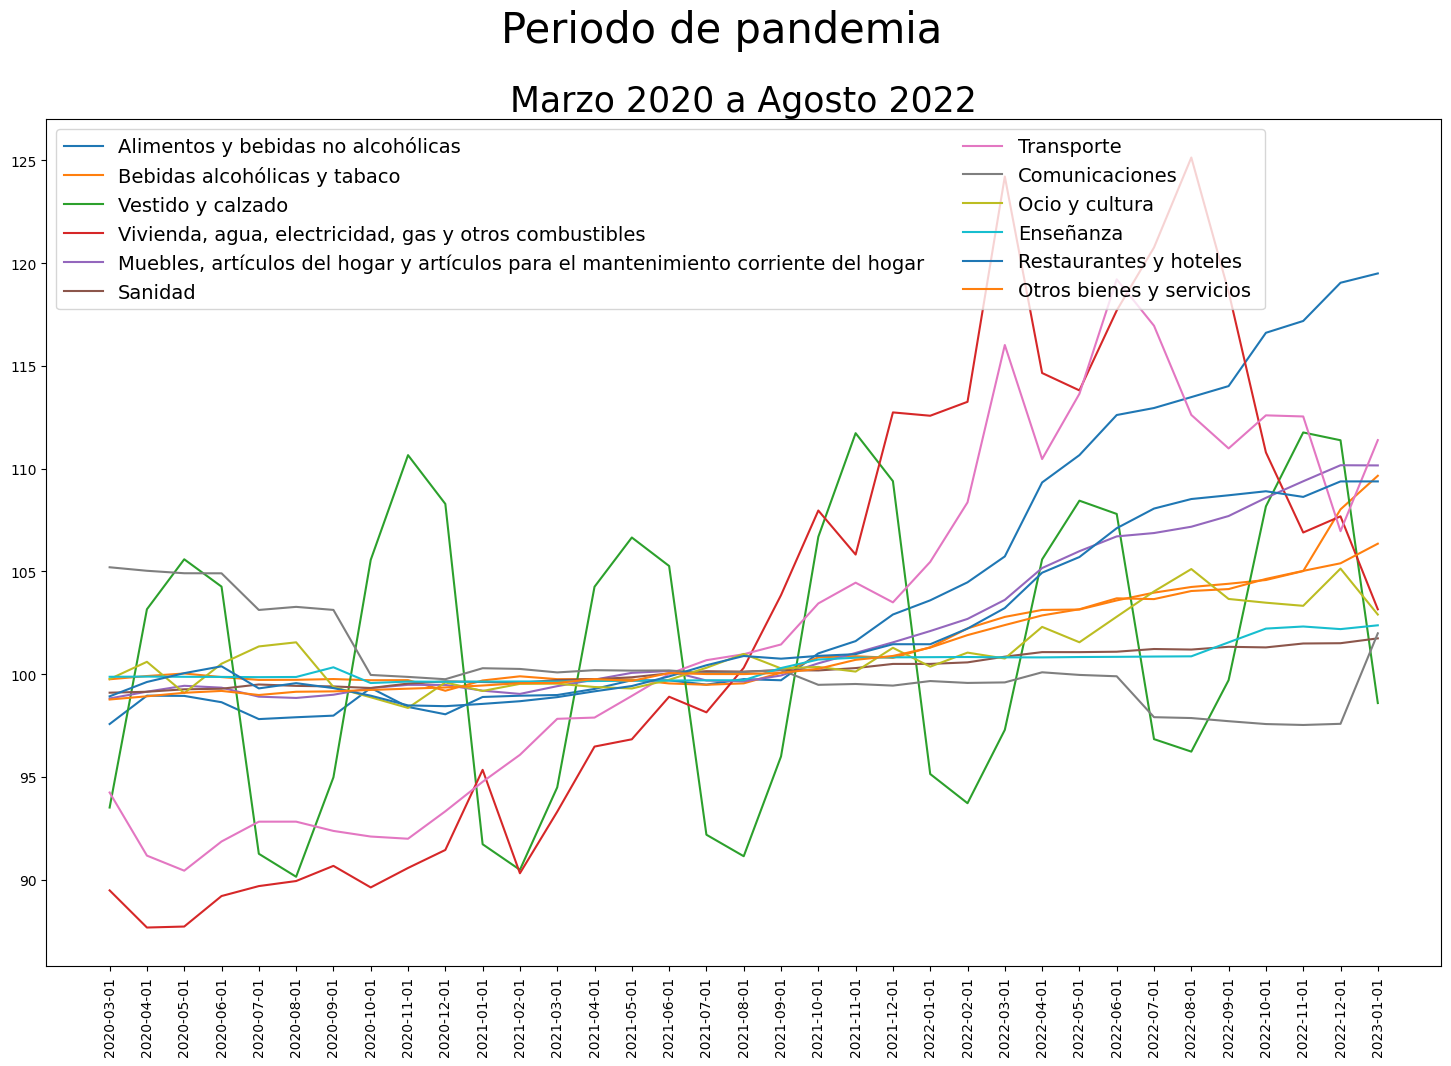

In [ ]:
plt.figure(figsize=(18,11))
x = range(0,datos_P4.shape[0])
labels = [d.date() for d in datos_P4.index]
plt.plot(x,datos_P4)
plt.legend(ECOICOP,fontsize = 14,ncol = 2)
plt.xticks(x, labels, rotation='vertical')
plt.title("Marzo 2020 a Agosto 2022",fontsize=25)
plt.suptitle("Periodo de pandemia",fontsize=30)
plt.show()


## Matrices de distancias y disimilaridades

En este punto del desarrollo comienza el quiz del problema en torno al que gira todo el trabajo: cuantificar la distancia entre dos series temporales.

### Distancia entre observaciones

In [33]:
# Función 'Distancia entre dos series', con posibilidad a especificar los pesos
def dobs(s1,s2,pesos):
  if len(s1) != len(s2): 
    print('No se puede usar este algoritmo con series de distinta longitud.')
    return()
  l = len(s1)
  SumaPonderada = 0
  for i in range(l):
    SumaPonderada += (s1[i]-s2[i])**2*pesos[i]
  res = np.sqrt(SumaPonderada)
  return(res)

# Función para definir la matriz de distancias
def matriz(Datos,pesos):
  n = Datos.shape[1]
  # pesos = np.ones(n)
  M = np.ones((n,n))
  for i in range(n):
    s1 = Datos[:,i]
    for j in range(i+1,n):
      s2 = Datos[:,j]
      d = dobs(s1,s2,pesos)
      M[i,j] = d
      M[j,i] = d
  return(M)

# Definición de las matrices de distancias para el conjunto de datos escogido
matdist_P1 = matriz(np.array(datos_P1),np.ones(datos_P1.shape[0]))
matdist_P2 = matriz(np.array(datos_P2),np.ones(datos_P2.shape[0]))
matdist_P3 = matriz(np.array(datos_P3),np.ones(datos_P3.shape[0]))
matdist_P4 = matriz(np.array(datos_P4),np.ones(datos_P4.shape[0]))

### Distancia entre velocidades

In [34]:
# Función para calcular la 'Velocidad de una serie'
def vel(serie):
  velocidad = []
  for i in range(1,len(serie)): # recordemos que python empieza a contar en 0
    v = serie[i] - serie[i-1]
    velocidad.append(v)
  return(velocidad)

# Función 'Distancia entre dos series', con posibilidad a especificar los pesos
def dvel(s1,s2,pesos):
  if len(s1) != len(s2): 
    print('No se puede usar este algoritmo con series de distinta longitud.')
    return()
  l = len(s1)
  v1 = vel(s1)
  v2 = vel(s2)
  SumaPonderada = 0
  for i in range(l-1):
    SumaPonderada += (v1[i]-v2[i])**2*pesos[i]
  res = np.sqrt(SumaPonderada)
  return(res)

# Función para definir la matriz de distancias
def matriz(Datos,pesos):
  n = Datos.shape[1]
  # pesos = np.ones(n)
  M = np.ones((n,n))
  for i in range(n):
    s1 = Datos[:,i]
    for j in range(i+1,n):
      s2 = Datos[:,j]
      d = dvel(s1,s2,pesos)
      M[i,j] = d
      M[j,i] = d
  return(M)

# Definición de las matrices de distancias para el conjunto de datos escogido
matdist_P1 = matriz(np.array(datos_P1),np.ones(datos_P1.shape[0]))
matdist_P2 = matriz(np.array(datos_P2),np.ones(datos_P2.shape[0]))
matdist_P3 = matriz(np.array(datos_P3),np.ones(datos_P3.shape[0]))
matdist_P4 = matriz(np.array(datos_P4),np.ones(datos_P4.shape[0]))

### Distancia entre aceleraciones

Las series tienen que tener al menor 3 observaciones. Además, deben ser series de igual longitud.

In [35]:
# Función para calcular la 'Aceleración de una serie'
def acc(serie):
  aceleracion = []
  for i in range(2,len(serie)): # recordemos que python empieza a contar en 0
    a = serie[i] - 2*serie[i-1] + serie[i-2]
    aceleracion.append(a)
  return(aceleracion)

# Función 'Distancia entre dos series', con posibilidad a especificar los pesos
def dacc(s1,s2,pesos):
  if len(s1) != len(s2): 
    print('No se puede usar este algoritmo con series de distinta longitud.')
    return()
  l = len(s1)
  a1 = acc(s1)
  a2 = acc(s2)
  SumaPonderada = 0
  for i in range(l-2):
    SumaPonderada += (a1[i]-a2[i])**2*pesos[i]
  res = np.sqrt(SumaPonderada)
  return(res)

# Función para definir la matriz de distancias
def matriz(Datos,pesos):
  n = Datos.shape[1]
  # pesos = np.ones(n)
  M = np.ones((n,n))
  for i in range(n):
    s1 = Datos[:,i]
    for j in range(i+1,n):
      s2 = Datos[:,j]
      d = dacc(s1,s2,pesos)
      M[i,j] = d
      M[j,i] = d
  return(M)

# Definición de las matrices de distancias para el conjunto de datos escogido
matdist_P1 = matriz(np.array(datos_P1),np.ones(datos_P1.shape[0]))
matdist_P2 = matriz(np.array(datos_P2),np.ones(datos_P2.shape[0]))
matdist_P3 = matriz(np.array(datos_P3),np.ones(datos_P3.shape[0]))
matdist_P4 = matriz(np.array(datos_P4),np.ones(datos_P4.shape[0]))

### Distancia entre áreas

In [36]:
# Importación de la libreria que calcula integrales
from scipy.integrate import quad

# Supongamos que x e y son de la misma longitud y los datos han sido observados en los mismos instantes
# Supongamos que los instantes están separados 1 unidad. 
# Por tanto, la recta entre dos observaciones de una misma serie viene dada por:
# y = (x-x_i)/(x_{i+1}-x_i)+i

# Función que calcula el área entre dos series de igual longitud
def area_entre_series(x, y):
  if len(x) != len(y): 
    print('Este método sólo está implementado para series de igual longitud')
    return
  n = len(x)
  area = 0
  for i in range(n-1):
    def f(z): 
      sol = (z-x[i])/(x[i+1]-x[i]) + i
      return(sol)
    def g(s): 
      sol = (s-y[i])/(y[i+1]-y[i]) + i
      return(sol)
    integral, error = quad(lambda t: f(t) - g(t), i, i+1) 
    area += integral
    return area


In [37]:
# Se rellenan las matrices de distancias
for D,M in [[datos_P1,matdist_P1],[datos_P2,matdist_P2],[datos_P3,matdist_P3],[datos_P4,matdist_P4]]:
  for i in range(len(ECOICOP)):
    for j in range(i+1,len(ECOICOP)):
      dist = area_entre_series(D.iloc[:,i],D.iloc[:,j])
      M[i,j] = dist
      M[j,i] = dist

### Distancia DTW


La distancia DTW ya está implementada en el módulo *dtaidistance*, por lo que se empleará para el cálculo de la distancia entre series.

In [38]:
!pip install dtaidistance
from dtaidistance import dtw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 26.8 MB/s eta 0:00:00


In [39]:
# Definición de las matrices de distancias para el conjunto de datos escogido
matdist_P1 = dtw.distance_matrix_fast(np.array(datos_P1.transpose()),compact = False)
matdist_P2 = dtw.distance_matrix_fast(np.array(datos_P2.transpose()),compact = False)
matdist_P3 = dtw.distance_matrix_fast(np.array(datos_P3.transpose()),compact = False)
matdist_P4 = dtw.distance_matrix_fast(np.array(datos_P4.transpose()),compact = False)

### Distancia entre FACV

Las funciones de autocovarianzas y autocorrelaciones, así como el correlograma, están disponibles en la librería *statsmodels*.

In [40]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf, acovf

In [41]:
# Definición de las matrices de distancias para el conjunto de datos escogido
matdist_P1 = np.zeros([len(ECOICOP),len(ECOICOP)])
matdist_P2 = np.zeros([len(ECOICOP),len(ECOICOP)])
matdist_P3 = np.zeros([len(ECOICOP),len(ECOICOP)])
matdist_P4 = np.zeros([len(ECOICOP),len(ECOICOP)])

# Se rellenan las matrices de distancias
for dat,mat in [[datos_P1,matdist_P1],[datos_P1,matdist_P2],[datos_P1,matdist_P3],[datos_P1,matdist_P4]]:
  for i in range(len(ECOICOP)):
    acvs_i = acovf(dat.iloc[:,i]) # Calcular la función de autocovarianzas
    for j in range(i+1,len(ECOICOP)):
      acvs_j = acovf(dat.iloc[:,j])
      mat[i,j] = np.sqrt(sum((acvs_i-acvs_j)**2)) # como matriz pesos se toma la identidad
      mat[j,i] = mat[i,j]



### Distancia entre FAC

In [42]:
# Definición de las matrices de distancias para el conjunto de datos escogido
matdist_P1 = np.zeros([len(ECOICOP),len(ECOICOP)])
matdist_P2 = np.zeros([len(ECOICOP),len(ECOICOP)])
matdist_P3 = np.zeros([len(ECOICOP),len(ECOICOP)])
matdist_P4 = np.zeros([len(ECOICOP),len(ECOICOP)])

for dat,mat in [[datos_P1,matdist_P1],[datos_P1,matdist_P2],[datos_P1,matdist_P3],[datos_P1,matdist_P4]]:
  for i in range(len(ECOICOP)):
    # Calcular la función de autocorrelaciones
    acr_i = acf(dat.iloc[:,i], adjusted=False, nlags=int(len(dat.iloc[:,i])/4), fft=False, bartlett_confint=False, missing='none')
    for j in range(i+1,len(ECOICOP)):
      acr_j = acf(dat.iloc[:,j], adjusted=False, nlags=int(len(dat.iloc[:,j])/4), fft=False, bartlett_confint=False, missing='none')
      mat[i,j] = np.sqrt(sum((acr_i-acr_j)**2)) # como matriz pesos elegimos la identidad
      mat[j,i] = mat[i,j]



### Distancia entre correlogramas

In [43]:
# Definición de las matrices de distancias para el conjunto de datos escogido
matdist_P1 = np.zeros([len(ECOICOP),len(ECOICOP)])
matdist_P2 = np.zeros([len(ECOICOP),len(ECOICOP)])
matdist_P3 = np.zeros([len(ECOICOP),len(ECOICOP)])
matdist_P4 = np.zeros([len(ECOICOP),len(ECOICOP)])

# Se rellenan las matrices de distancias
for dat,mat in [[datos_P1,matdist_P1],[datos_P1,matdist_P2],[datos_P1,matdist_P3],[datos_P1,matdist_P4]]:
  for i in range(len(ECOICOP)):
    # Calcular la función de autocorrelaciones
    acr_i = acf(dat.iloc[:,i], adjusted=False, nlags=int(len(dat.iloc[:,i])/4), fft=False, bartlett_confint=False, missing='none')
    for j in range(i+1,len(ECOICOP)):
      acr_j = acf(dat.iloc[:,j], adjusted=False, nlags=int(len(dat.iloc[:,j])/4), fft=False, bartlett_confint=False, missing='none')
      mat[i,j] = np.sqrt(sum(abs(acr_i)-abs(acr_j))**2)
      mat[j,i] = mat[i,j]


### Basada en los coeficientes del modelo RLM

El modelo de regresión lineal múltiple se puede ajustar usando la librería *sklearn*, y las medidas relacionadas con dicho modelo, también.

In [45]:
# Importación de las funciones necesarias
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  mean_squared_error, r2_score

In [49]:
# Se guardarán las medidas MSE y R^2 para visualizar la bondad de los modelos
MSE = []
R2 = []

# La lista de coeficientes de cada modelo se guardarán en una lista
modelos = [] 

# Elección del modelo de interés
lm = LinearRegression(fit_intercept=True)
    
for d in [datos_P1,datos_P2,datos_P3,datos_P4]:
  datos_P = d.copy()
  # Defnición de las variables dummy, que representan el mes (11 variables dummy), y la variable tiempo.
  # Se añaden estas variables al dataset inicial
  datos_P["dummy1"] = [int(date.month == 1) for date in datos_P.index]
  datos_P["dummy2"] = [int(date.month == 2) for date in datos_P.index]
  datos_P["dummy3"] = [int(date.month == 3) for date in datos_P.index]
  datos_P["dummy4"] = [int(date.month == 4) for date in datos_P.index]
  datos_P["dummy5"] = [int(date.month == 5) for date in datos_P.index]
  datos_P["dummy6"] = [int(date.month == 6) for date in datos_P.index]
  datos_P["dummy7"] = [int(date.month == 7) for date in datos_P.index]
  datos_P["dummy8"] = [int(date.month == 8) for date in datos_P.index]
  datos_P["dummy9"] = [int(date.month == 9) for date in datos_P.index]
  datos_P["dummy10"] = [int(date.month == 10) for date in datos_P.index]
  datos_P["dummy11"] = [int(date.month == 11) for date in datos_P.index]
  datos_P["dummy12"] = [int(date.month == 12) for date in datos_P.index]
  datos_P["tiempo"] = [i for i in range(datos_P.shape[0])]

  # Regresión lineal
  for Y in datos_P.columns[range(len(ECOICOP))]:
    datos = datos_P[[Y,"dummy1","dummy2","dummy3","dummy4","dummy5","dummy6","dummy7","dummy8","dummy9","dummy10","dummy11","dummy12","tiempo"]]
    # Se ajusta el modelo a los datos
    reg = lm.fit(datos.drop(columns = [Y]), datos[Y])
    modelos.append(reg.coef_)
    # Se predice con el modelo ajustado en los datos para analizar los residuos
    predictions = reg.predict(datos.drop(columns = [Y]))
    # Calculamos métricas a partir de las predicciones para comprobar la bondad del modelo
    MSE.append(np.sqrt(mean_squared_error(predictions, datos[Y])))
    R2.append(r2_score(predictions, datos[Y]))
  

Para estudiar el comportamiento de los modelos ajustados, se representan la evolución del error cuadrático medio para cada modelo y la evolución del $R^2$.

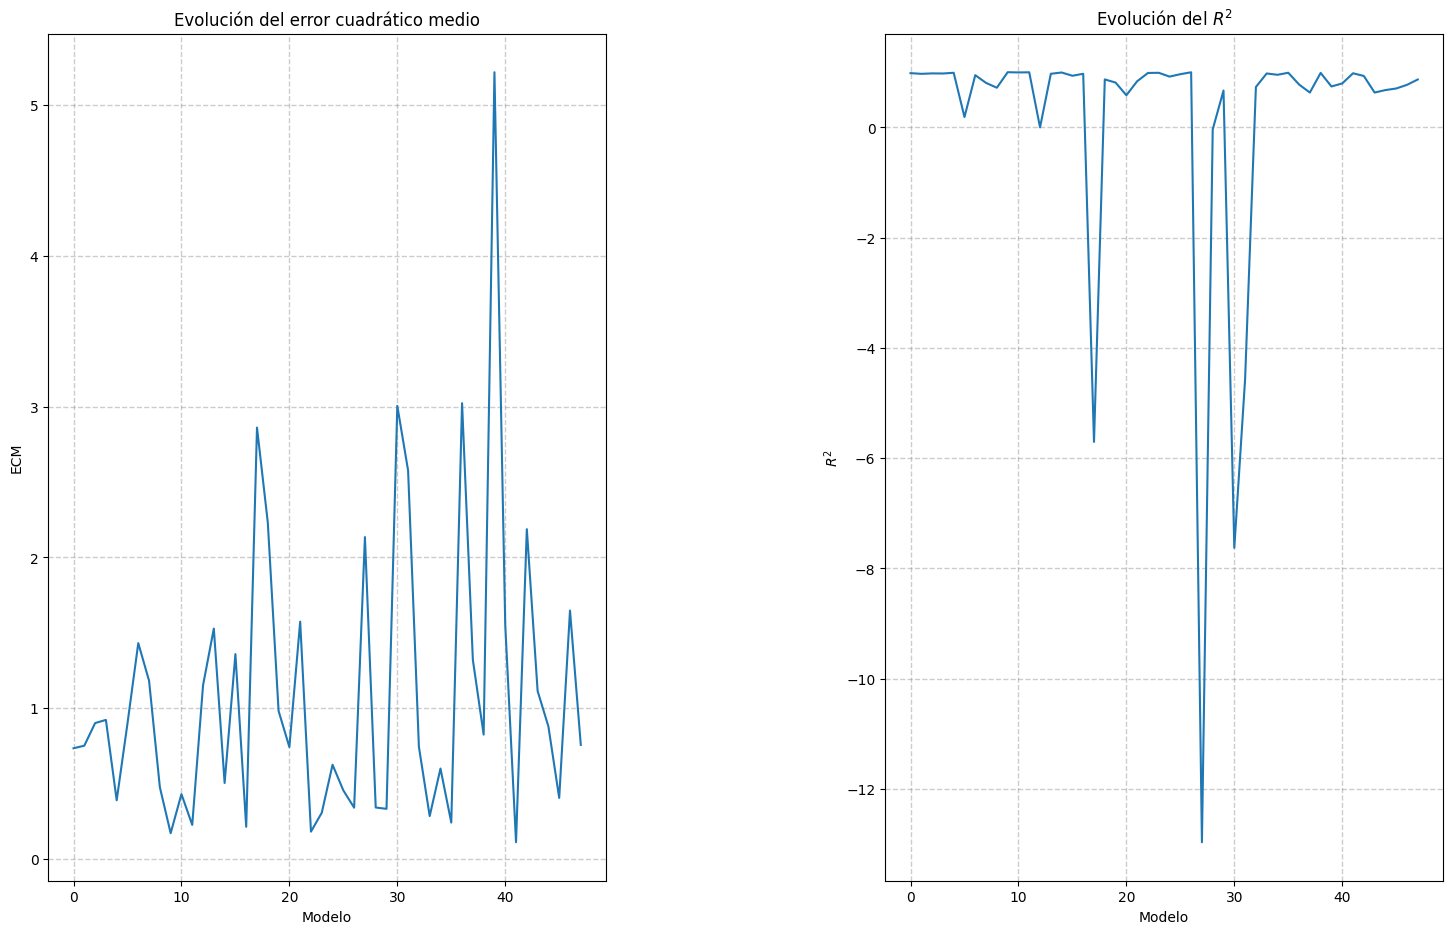

In [50]:
fig1 = plt.figure(figsize=(18,11))
fig1.subplots_adjust(hspace=0.5, wspace=0.5)

ax = fig1.add_subplot(1,2,1)
ax.plot(MSE)
ax.set_title('Evolución del error cuadrático medio')
ax.set_xlabel('Modelo')
ax.set_ylabel('ECM')
ax.grid(color='gray', linestyle='dashed', linewidth=1, alpha=0.4)

ax = fig1.add_subplot(1,2,2)
ax.plot(R2)
ax.set_title('Evolución del $R^2$')
ax.set_xlabel('Modelo')
ax.set_ylabel('$R^2$')
ax.grid(color='gray', linestyle='dashed', linewidth=1, alpha=0.4)

In [51]:
# Definición de las matrices de distancias para el conjunto de datos escogido
matdist_P1 = np.zeros([len(ECOICOP),len(ECOICOP)])
matdist_P2 = np.zeros([len(ECOICOP),len(ECOICOP)])
matdist_P3 = np.zeros([len(ECOICOP),len(ECOICOP)])
matdist_P4 = np.zeros([len(ECOICOP),len(ECOICOP)])

# Se completa la matriz de distancias
p = 0
for mat in [matdist_P1,matdist_P2,matdist_P3,matdist_P4]:
  for i in range(len(ECOICOP)):
    for j in range(i+1,len(ECOICOP)):
      mat[i,j] = np.linalg.norm(modelos[p+i]-modelos[p+j]) # distancia euclidea entre los vectores de coeficientes
      mat[j,i] = mat[i,j]
  p += 12

### Basada en los coeficientes del modelo ARIMA

La librería *pmdarima* contiene la función *auto_arima*, que conviene usar para el ajuste automático de modelos ARIMA.

In [52]:
!pip install pmdarima
from pmdarima.arima import auto_arima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 20.3 MB/s eta 0:00:00


In [53]:
# Se guardan medidas relacionadas con los modelos ARIMA para visualizar la bondad de los modelos
MSE = []
AIC = []

# La lista de coeficientes de cada modelo se guardarán en una lista
modelos = [] 
    
for d in [datos_P1,datos_P2,datos_P3,datos_P4]:
  for k in range(len(d.columns)):
    # ARIMA
    model = auto_arima(d.iloc[:,k], seasonal=True, m=12, 
                   start_p=0, start_q=0, max_p=2, max_q=2,
                   start_P=0, start_Q=0, max_P=2, max_Q=2,
                   trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
    modelos.append(model.params())
    predictions = model.predict_in_sample(d.iloc[:,k])
    MSE.append(np.sqrt(mean_squared_error(predictions, d.iloc[:,k])))
    AIC.append(model.aic())
  


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=27.263, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=15.513, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=17.946, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=73.077, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=21.951, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=13.037, Time=1.70 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.54 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=13.279, Time=0.57 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=23.336, Time=0.60 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=13.979, Time=0.94 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=14.129, Time=0.96 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=12.582, Time=0.66 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=15.152, Time=0.18 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=3.04 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=13.398, Ti

Para estudiar el comportamiento de los modelos ajustados, se representan la evolución del error cuadrático medio para cada modelo y la evolución del Criterio de Información de Akaike (AIC).

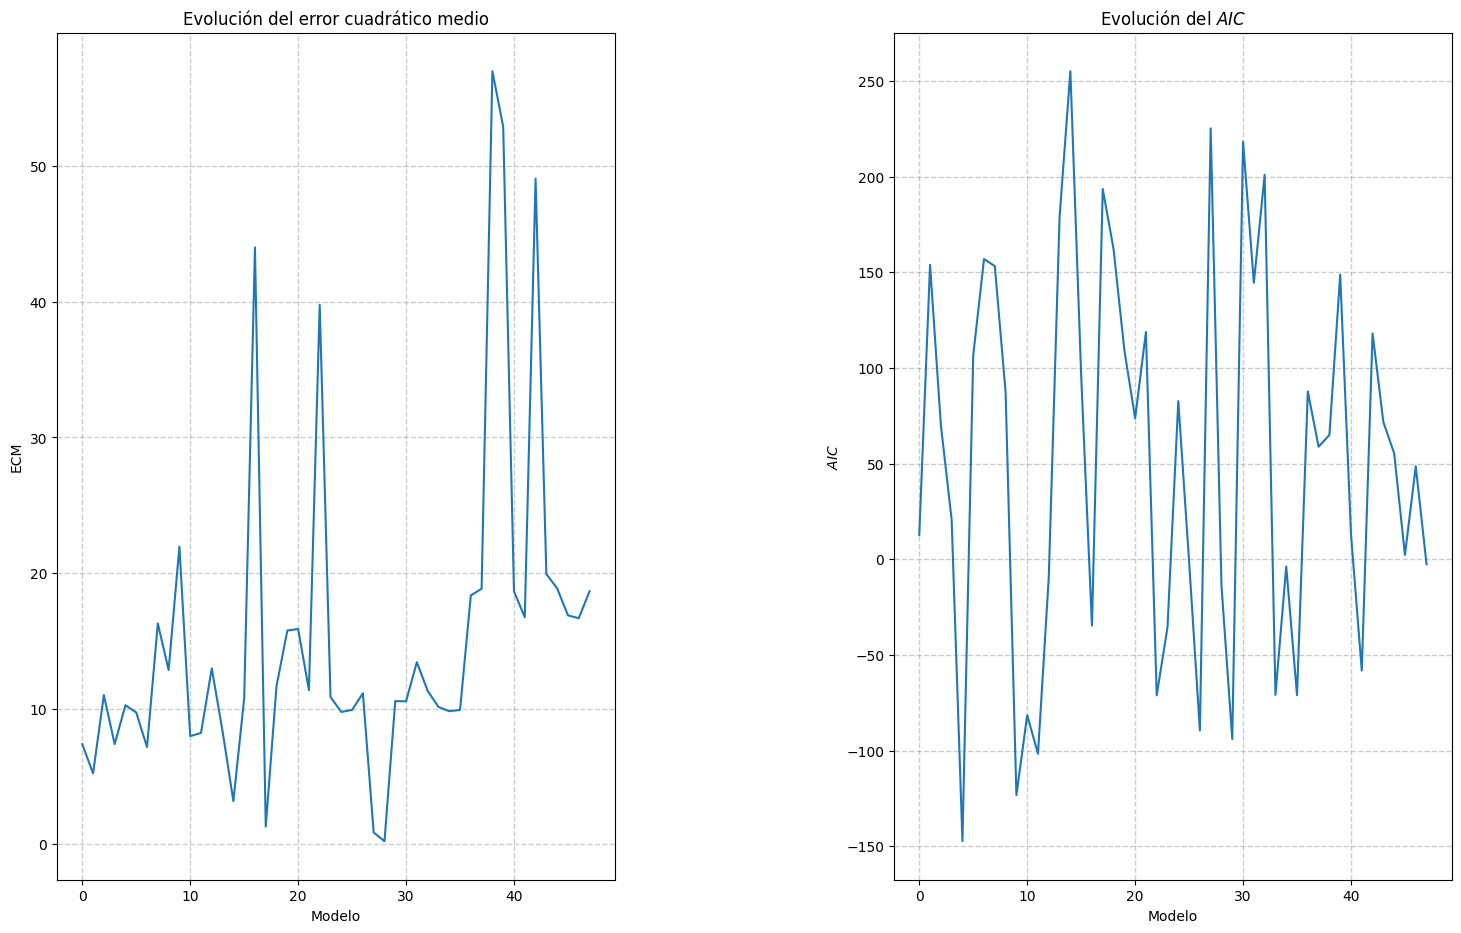

In [54]:
fig1 = plt.figure(figsize=(18,11))
fig1.subplots_adjust(hspace=0.5, wspace=0.5)

ax = fig1.add_subplot(1,2,1)
ax.plot(MSE)
ax.set_title('Evolución del error cuadrático medio')
ax.set_xlabel('Modelo')
ax.set_ylabel('ECM')
ax.grid(color='gray', linestyle='dashed', linewidth=1, alpha=0.4)

ax = fig1.add_subplot(1,2,2)
ax.plot(AIC)
ax.set_title('Evolución del $AIC$')
ax.set_xlabel('Modelo')
ax.set_ylabel('$AIC$')
ax.grid(color='gray', linestyle='dashed', linewidth=1, alpha=0.4)

In [55]:
# Definición de las matrices de distancias para el conjunto de datos escogido
matdist_P1 = np.zeros([len(ECOICOP),len(ECOICOP)])
matdist_P2 = np.zeros([len(ECOICOP),len(ECOICOP)])
matdist_P3 = np.zeros([len(ECOICOP),len(ECOICOP)])
matdist_P4 = np.zeros([len(ECOICOP),len(ECOICOP)])

# Se completa la matriz de distancias
p = 0
for mat in [matdist_P1,matdist_P2,matdist_P3,matdist_P4]:
  for i in range(len(ECOICOP)):
    for j in range(i+1,len(ECOICOP)):
      x = modelos[i]-modelos[j]
      x = x[~np.isnan(x)]
      mat[i,j] = np.linalg.norm(x)
      mat[j,i] = mat[i,j]
  p += 12

### Basada en el error de predicción con modelos RLM

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  mean_squared_error

In [69]:
# Contruimos matrices de ceros para rellenarlas
matdist_P1 = np.zeros([len(ECOICOP),len(ECOICOP)])
matdist_P2 = np.zeros([len(ECOICOP),len(ECOICOP)])
matdist_P3 = np.zeros([len(ECOICOP),len(ECOICOP)])
matdist_P4 = np.zeros([len(ECOICOP),len(ECOICOP)])

# Elección del modelo de interés
lm = LinearRegression(fit_intercept=True)
    
for d,matdist_P in [[datos_P1,matdist_P1],[datos_P2,matdist_P2],[datos_P3,matdist_P3],[datos_P4,matdist_P4]]:
  datos_P = d.copy()
  # Definición de las variables dummy, que representen el mes (11 variables dummy), y la variable tiempo.
  # Se añaden las variables al dataset inicial
  datos_P["dummy1"] = [int(date.month == 1) for date in datos_P.index]
  datos_P["dummy2"] = [int(date.month == 2) for date in datos_P.index]
  datos_P["dummy3"] = [int(date.month == 3) for date in datos_P.index]
  datos_P["dummy4"] = [int(date.month == 4) for date in datos_P.index]
  datos_P["dummy5"] = [int(date.month == 5) for date in datos_P.index]
  datos_P["dummy6"] = [int(date.month == 6) for date in datos_P.index]
  datos_P["dummy7"] = [int(date.month == 7) for date in datos_P.index]
  datos_P["dummy8"] = [int(date.month == 8) for date in datos_P.index]
  datos_P["dummy9"] = [int(date.month == 9) for date in datos_P.index]
  datos_P["dummy10"] = [int(date.month == 10) for date in datos_P.index]
  datos_P["dummy11"] = [int(date.month == 11) for date in datos_P.index]
  datos_P["dummy12"] = [int(date.month == 12) for date in datos_P.index]
  datos_P["tiempo"] = [i for i in range(datos_P.shape[0])]

  # Regresión lineal 
  linea = 0 # para movernos en la matriz de distancias
  for Y in datos_P.columns[range(len(ECOICOP))]:
    datos = datos_P[[Y,"dummy1","dummy2","dummy3","dummy4","dummy5","dummy6","dummy7","dummy8","dummy9","dummy10","dummy11","dummy12","tiempo"]]
    # Se ajusta el modelo a los datos
    reg = lm.fit(datos.drop(columns = [Y]), datos[Y])
    columna = 0 # para movernos en la matriz de distancias
    predictions = reg.predict(datos.drop(columns = [Y]))
    # Se compara la predicción con los valores observados de cada serie
    for Z in datos_P.columns[range(len(ECOICOP))]:
      # Se rellena la matriz de distancias
      matdist_P[linea,columna] = np.sqrt(mean_squared_error(predictions, datos_P[Z])) # raiz error cuadratico medio
      columna += 1
    linea += 1  

Como las matrices construidas no son simétricas ni tienen la diagonal compuesta por ceros, en general, es necesario adaptarla para que lo sea. 

In [70]:
# Definición de las matrices de distancias para el conjunto de datos escogido
matdist_P1 = np.zeros([len(ECOICOP),len(ECOICOP)])
matdist_P2 = np.zeros([len(ECOICOP),len(ECOICOP)])
matdist_P3 = np.zeros([len(ECOICOP),len(ECOICOP)])
matdist_P4 = np.zeros([len(ECOICOP),len(ECOICOP)])

# Se completa la matriz de distancias
for matdist in [matdist_P1,matdist_P2,matdist_P3,matdist_P4]:
  for i in range(matdist.shape[0]):
    matdist[i,i] = 0
    for j in range(i+1,matdist.shape[1]):
      m = max(matdist[i,j],matdist[j,i]) # tomamos el maximo y no el minimo para que las diferencias sean más significantes
      matdist[i,j] = m
      matdist[j,i] = m

### Basada en el error de predicción con modelos ARIMA

In [71]:
!pip install pmdarima
from pmdarima.arima import auto_arima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [72]:
# Definición de las matrices de distancias
matdist_P1 = np.zeros([len(ECOICOP),len(ECOICOP)])
matdist_P2 = np.zeros([len(ECOICOP),len(ECOICOP)])
matdist_P3 = np.zeros([len(ECOICOP),len(ECOICOP)])
matdist_P4 = np.zeros([len(ECOICOP),len(ECOICOP)])

for d,m in [[datos_P1,matdist_P1],[datos_P2,matdist_P2],[datos_P3,matdist_P3],[datos_P4,matdist_P4]]:
  for k in range(len(d.columns)):
    # ARIMA
    model = auto_arima(d.iloc[:,k], seasonal=True, m=12, 
                   start_p=0, start_q=0, max_p=2, max_q=2,
                   start_P=0, start_Q=0, max_P=2, max_Q=2,
                   trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
    for s in range(len(d.columns)):
      predictions = model.predict_in_sample(d.iloc[:,s])
      m[k,s] = np.sqrt(mean_squared_error(predictions, d.iloc[:,s])) # raiz error cuadratico medio

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=27.263, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=15.513, Time=0.19 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=17.946, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=73.077, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=21.951, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=13.037, Time=0.87 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.69 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=13.279, Time=0.72 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=23.336, Time=0.75 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=13.979, Time=0.99 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=14.129, Time=1.97 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=12.582, Time=1.61 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=15.152, Time=0.89 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=inf, Time=5.53 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=13.398, Ti

In [74]:
# Se rellenan las matrices
for matdist in [matdist_P1,matdist_P2,matdist_P3,matdist_P4]:
  for i in range(matdist.shape[0]):
    matdist[i,i] = 0
    for j in range(i+1,matdist.shape[1]):
      m = max(matdist[i,j],matdist[j,i]) # tomamos el maximo y no el minimo para que las diferencias sean más significantes
      matdist[i,j] = m
      matdist[j,i] = m

### Basada en los coeficientes del modelo de cadenas de Markov ocultas

La librería *hmmlearn* contiene la función *hmm*, para el ajuste de modelos de cadenas de Markov ocultas (Hidden Markov Models).

In [75]:
!pip install hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [76]:
from hmmlearn import hmm

n_states = 5 # número de estados ocultos, que seran los diferentes clusters

# Se prepara un contenedor de resultados
conglomerados1 = pd.DataFrame({'Conglomerado1': range(len(ECOICOP)),'ECOICOP': ECOICOP})
conglomerados2 = pd.DataFrame({'Conglomerado2': range(len(ECOICOP)),'ECOICOP': ECOICOP})
conglomerados3 = pd.DataFrame({'Conglomerado3': range(len(ECOICOP)),'ECOICOP': ECOICOP})
conglomerados4 = pd.DataFrame({'Conglomerado4': range(len(ECOICOP)),'ECOICOP': ECOICOP})

count = 1
# Para cada conjunto de datos repetimos el mismo proceso:
for D,C in [[datos_P1.transpose(),conglomerados1],[datos_P2.transpose(),conglomerados2],[datos_P3.transpose(),conglomerados3],[datos_P4.transpose(),conglomerados4]]:
  name = 'Conglomerado'+str(count)
  
  # Definimos el tipo de distribución
  model = hmm.GaussianHMM(n_components=n_states)

  # Entrenamos el modelo en los datos
  model.fit(D)

  # Predecimos la secuencia de estados ocultos
  hidden_states = model.predict(D)
  
  # print("Secuencia de estados ocultos : ", hidden_states)
  # print("Probabilidad de cada estado oculto : \n", np.round(model.predict_proba(D)))

  # Se guarda el resultado
  C[name] = hidden_states
  count += 1


In [77]:
# Unificamos los resultados en un DataFrame que represente la evolución
conglomerados12 = conglomerados1.merge(conglomerados2,on = "ECOICOP")
conglomerados123 = conglomerados12.merge(conglomerados3,on = "ECOICOP")
conglomerados_evolucion = conglomerados123.merge(conglomerados4,on = "ECOICOP")

# Pasamos el conjunto de datos a DataFrame
conglomerados_evolucion = pd.DataFrame({'Periodo1':[c for c in conglomerados_evolucion['Conglomerado1']],
                                       'Periodo2':[c for c in conglomerados_evolucion['Conglomerado2']],
                                       'Periodo3':[c for c in conglomerados_evolucion['Conglomerado3']],
                                       'Periodo4':[c for c in conglomerados_evolucion['Conglomerado4']]},
                                       index = conglomerados_evolucion['ECOICOP'])
conglomerados_evolucion.index.rename("Grupos ECOICOP", inplace = True)
conglomerados_evolucion['ECOICOP'] = [i for i in range(len(ECOICOP))]
conglomerados_evolucion

Periodo1  Periodo2  \
Grupos ECOICOP                                                           
Alimentos y bebidas no alcohólicas                         4         1   
Bebidas alcohólicas y tabaco                               1         4   
Vestido y calzado                                          0         0   
Vivienda, agua, electricidad, gas y otros combu...         1         1   
Muebles, artículos del hogar y artículos para e...         0         0   
Sanidad                                                    0         1   
Transporte                                                 4         1   
Comunicaciones                                             2         2   
Ocio y cultura                                             3         3   
Enseñanza                                                  1         4   
Restaurantes y hoteles                                     4         1   
Otros bienes y servicios                                   4         1   

                                                    Periodo3  Periodo4  \
Grupos ECOICOP                                                           
Alimentos y bebidas no alcohólicas                         0         1   
Bebidas alcohólicas y tabaco                               2         2   
Vestido y calzado                                          3         3   
Vivienda, agua, electricidad, gas y otros combu...         4         0   
Muebles, artículos del hogar y artículos para e...         2         1   
Sanidad                                                    2         2   
Transporte                                                 4         4   
Comunicaciones                                             1         2   
Ocio y cultura                                             1         2   
Enseñanza                                                  2         2   
Restaurantes y hoteles                                     0         1   
Otros bienes y servicios                                   0         2   

                                                    ECOICOP  
Grupos ECOICOP                                               
Alimentos y bebidas no alcohólicas                        0  
Bebidas alcohólicas y tabaco                              1  
Vestido y calzado                                         2  
Vivienda, agua, electricidad, gas y otros combu...        3  
Muebles, artículos del hogar y artículos para e...        4  
Sanidad                                                   5  
Transporte                                                6  
Comunicaciones                                            7  
Ocio y cultura                                            8  
Enseñanza                                                 9  
Restaurantes y hoteles                                   10  
Otros bienes y servicios                                 11

## Clustering

### Jerárquico aglomerativo

In [78]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

<ipython-input-79-9597917d6756>:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  model_P1 = linkage(matdist_P1, method='average', metric='euclidean', optimal_ordering=False)


Text(0, 0.5, '')

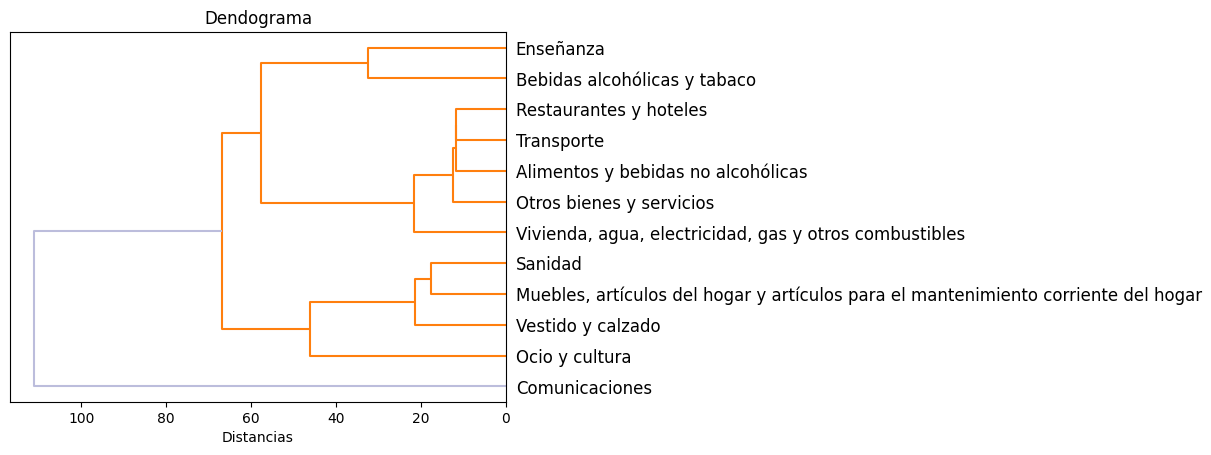

In [79]:
model_P1 = linkage(matdist_P1, method='average', metric='euclidean', optimal_ordering=False)
dendograma = dendrogram(model_P1,labels = ECOICOP,leaf_rotation = 0, above_threshold_color='#bcbddc', orientation='left')
plt.title('Dendograma')
plt.xlabel('Distancias')
plt.ylabel('')

<ipython-input-80-ccf47ec17f62>:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  model_P2 = linkage(matdist_P2, method='average', metric='euclidean', optimal_ordering=False)


Text(0, 0.5, '')

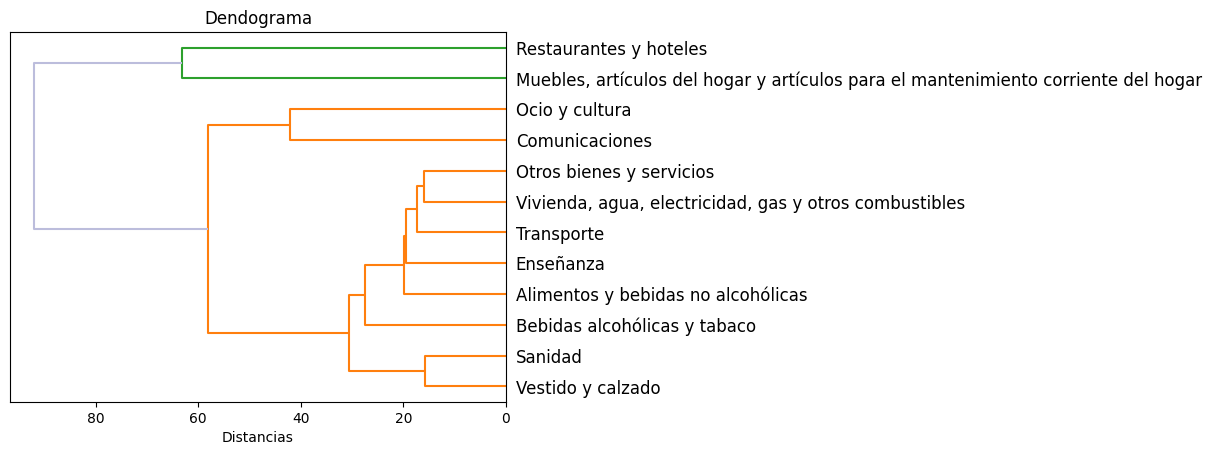

In [80]:
model_P2 = linkage(matdist_P2, method='average', metric='euclidean', optimal_ordering=False)
dendograma = dendrogram(model_P2,labels = ECOICOP,leaf_rotation = 0, above_threshold_color='#bcbddc', orientation='left')
plt.title('Dendograma')
plt.xlabel('Distancias')
plt.ylabel('')

<ipython-input-81-bcbe0df23cec>:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  model_P3 = linkage(matdist_P3, method='average', metric='euclidean', optimal_ordering=False)


Text(0, 0.5, '')

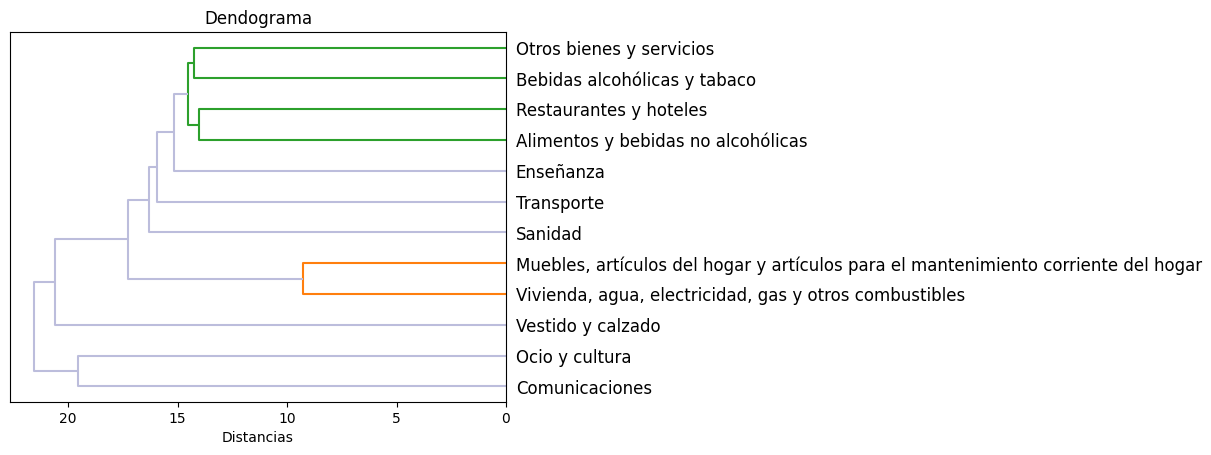

In [81]:
model_P3 = linkage(matdist_P3, method='average', metric='euclidean', optimal_ordering=False)
dendograma = dendrogram(model_P3,labels = ECOICOP,leaf_rotation = 0, above_threshold_color='#bcbddc', orientation='left')
plt.title('Dendograma')
plt.xlabel('Distancias')
plt.ylabel('')

<ipython-input-82-08b3c7e834c0>:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  model_P4 = linkage(matdist_P4, method='average', metric='euclidean', optimal_ordering=False)


Text(0, 0.5, '')

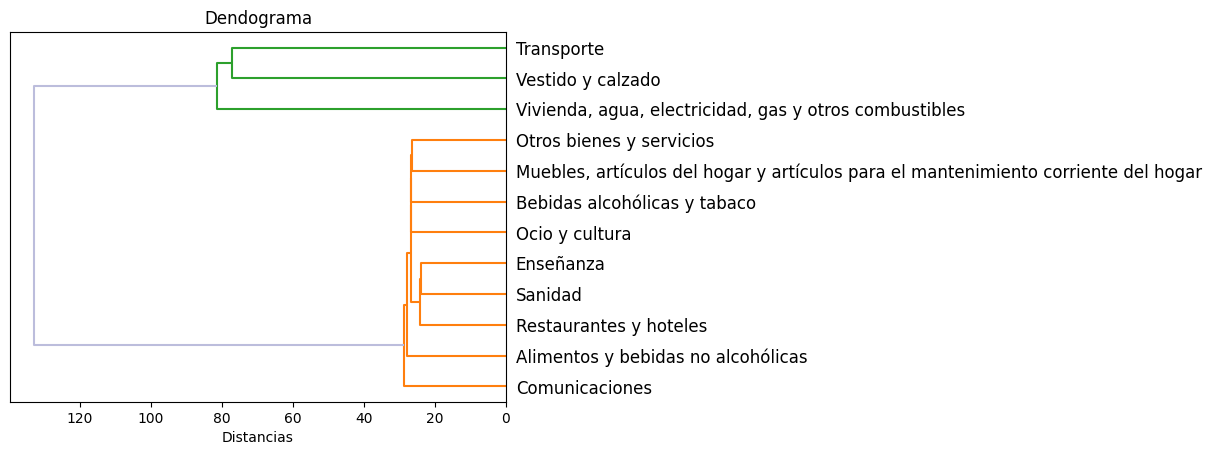

In [82]:
model_P4 = linkage(matdist_P4, method='average', metric='euclidean', optimal_ordering=False)
dendograma = dendrogram(model_P4,labels = ECOICOP,leaf_rotation = 0, above_threshold_color='#bcbddc', orientation='left')
plt.title('Dendograma')
plt.xlabel('Distancias')
plt.ylabel('')

Como en cada periodo podriamos tomar un número distinto de conglomerados, vamos a unificar la decisión y escogeremos 5 conglomerados en cada periodo.

In [83]:
nclusters = n_states
clust_model1 = AgglomerativeClustering(n_clusters = nclusters, affinity = 'precomputed', linkage = 'average')
clust_model1.fit(matdist_P1)
clust_model1.labels_ # conglomerado en el que se encuentra cada comunidad autónoma

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


array([2, 4, 0, 2, 0, 0, 2, 3, 0, 1, 2, 2])

Vamos a contruir un DataFrame en el que quede más clara toda la información.

In [84]:
conglomerados1 = pd.DataFrame({'Conglomerado1': clust_model1.labels_,'ECOICOP': ECOICOP})

Esto mismo lo repetimos para cada periodo.

In [85]:
# Periodo 2
clust_model2 = AgglomerativeClustering(n_clusters = nclusters, affinity = 'precomputed', linkage = 'average')
clust_model2.fit(matdist_P2)

conglomerados2 = pd.DataFrame({'Conglomerado2': clust_model2.labels_,'ECOICOP': ECOICOP})

# Periodo 3
clust_model3 = AgglomerativeClustering(n_clusters = nclusters, affinity = 'precomputed', linkage = 'average')
clust_model3.fit(matdist_P3)

conglomerados3 = pd.DataFrame({'Conglomerado3': clust_model3.labels_,'ECOICOP': ECOICOP})

# Periodo 4
clust_model4 = AgglomerativeClustering(n_clusters = nclusters, affinity = 'precomputed', linkage = 'average')
clust_model4.fit(matdist_P4)

conglomerados4 = pd.DataFrame({'Conglomerado4': clust_model4.labels_,'ECOICOP': ECOICOP})

# Unificamos los resultados en un DataFrame que represente la evolución
conglomerados12 = conglomerados1.merge(conglomerados2,on = "ECOICOP")
conglomerados123 = conglomerados12.merge(conglomerados3,on = "ECOICOP")
conglomerados_evolucion = conglomerados123.merge(conglomerados4,on = "ECOICOP")

# Pasamos el conjunto de datos a DataFrame
conglomerados_evolucion = pd.DataFrame({'Periodo1':[c for c in conglomerados_evolucion['Conglomerado1']],
                                       'Periodo2':[c for c in conglomerados_evolucion['Conglomerado2']],
                                       'Periodo3':[c for c in conglomerados_evolucion['Conglomerado3']],
                                       'Periodo4':[c for c in conglomerados_evolucion['Conglomerado4']]},
                                       index = conglomerados_evolucion['ECOICOP'])
conglomerados_evolucion.index.rename("Grupos ECOICOP", inplace = True)
conglomerados_evolucion['ECOICOP'] = [i for i in range(len(ECOICOP))]
conglomerados_evolucion

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


Periodo1  Periodo2  \
Grupos ECOICOP                                                           
Alimentos y bebidas no alcohólicas                         2         0   
Bebidas alcohólicas y tabaco                               4         0   
Vestido y calzado                                          0         0   
Vivienda, agua, electricidad, gas y otros combu...         2         0   
Muebles, artículos del hogar y artículos para e...         0         3   
Sanidad                                                    0         0   
Transporte                                                 2         0   
Comunicaciones                                             3         4   
Ocio y cultura                                             0         1   
Enseñanza                                                  1         0   
Restaurantes y hoteles                                     2         2   
Otros bienes y servicios                                   2         0   

                                                    Periodo3  Periodo4  \
Grupos ECOICOP                                                           
Alimentos y bebidas no alcohólicas                         1         0   
Bebidas alcohólicas y tabaco                               1         0   
Vestido y calzado                                          2         2   
Vivienda, agua, electricidad, gas y otros combu...         0         3   
Muebles, artículos del hogar y artículos para e...         0         0   
Sanidad                                                    0         0   
Transporte                                                 1         4   
Comunicaciones                                             3         1   
Ocio y cultura                                             4         0   
Enseñanza                                                  1         0   
Restaurantes y hoteles                                     1         0   
Otros bienes y servicios                                   1         0   

                                                    ECOICOP  
Grupos ECOICOP                                               
Alimentos y bebidas no alcohólicas                        0  
Bebidas alcohólicas y tabaco                              1  
Vestido y calzado                                         2  
Vivienda, agua, electricidad, gas y otros combu...        3  
Muebles, artículos del hogar y artículos para e...        4  
Sanidad                                                   5  
Transporte                                                6  
Comunicaciones                                            7  
Ocio y cultura                                            8  
Enseñanza                                                 9  
Restaurantes y hoteles                                   10  
Otros bienes y servicios                                 11

Una vez que tenemos el DataFrame de la evolución de conglomerados, pasamos a la sección **Conclusiones en el mapa** para ver en el mapa de España esta evolución.

### K-means

Lo interesante de esta sección es que debemos pasar las series de distancias al algoritmo en vez de las series originales.

Para utilizar KMeans del módulo sklearn.cluster es necesario tener las observaciones por líneas. ¿Qué conjunto de datos hemos de pasar al algoritmo? Porque está claro que no debemos pasarle el conjunto inicial, si no no tendría sentido diferenciar entre distancias. 

Realmente deberíamos pasarle un conjunto de datos que represente las distancias entre las series, y en base a eso iniciar el clustering.

Aún así, hemos de definir mejor este proceso. Si pasamos directamente las matrices de distancias, tampoco llegaremos al objetivo que nos interesa porque cada entrada de la matriz tiene un significado diferente. En cambio, nosotros buscamos un conjunto de datos cuyas filas sean las observaciones y las columnas sean las variables.

Siguiendo este razonamiento, se propone la siguiente solución:
tomamos como punto de referencia una de las series, supongamos la primera. A continuación calculamos todas las distancias únicamente respecto de esa serie. Así tendremos bien identificado el conjunto de datos y tendrá sentido hacer KMeans sobre él.

In [86]:
from sklearn.cluster import KMeans

In [87]:
n = len(ECOICOP)
vecdist_P1 = np.zeros((n,1))
vecdist_P2 = np.zeros((n,1))
vecdist_P3 = np.zeros((n,1))
vecdist_P4 = np.zeros((n,1))

for v,m in [[vecdist_P1,matdist_P1[0,:]],[vecdist_P2,matdist_P2[0,:]],[vecdist_P3,matdist_P3[0,:]],[vecdist_P4,matdist_P4[0,:]]]:
  for i in range(0,n):
    v[i,0] = m[i]

kmeans_P1 = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(vecdist_P1)
kmeans_P2 = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(vecdist_P2)
kmeans_P3 = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(vecdist_P3)
kmeans_P4 = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(vecdist_P4)

In [88]:
kmeans_P1.labels_
# kmeans.predict([[0, 0], [12, 3]])

# kmeans.cluster_centers_

array([2, 0, 0, 2, 0, 0, 2, 3, 1, 1, 2, 2], dtype=int32)

In [89]:
# Construimos un conjunto de datos que contenga los clusters por periodo y 
# los nombres de las observaciones

conglomerados1 = pd.DataFrame({'Conglomerado1': kmeans_P1.labels_,'ECOICOP': ECOICOP}) # Periodo 1
conglomerados2 = pd.DataFrame({'Conglomerado2': kmeans_P2.labels_,'ECOICOP': ECOICOP}) # Periodo 2
conglomerados3 = pd.DataFrame({'Conglomerado3': kmeans_P3.labels_,'ECOICOP': ECOICOP}) # Periodo 3
conglomerados4 = pd.DataFrame({'Conglomerado4': kmeans_P4.labels_,'ECOICOP': ECOICOP}) # Periodo 4

# Unificamos los resultados en un DataFrame que represente la evolución
conglomerados12 = conglomerados1.merge(conglomerados2,on = "ECOICOP")
conglomerados123 = conglomerados12.merge(conglomerados3,on = "ECOICOP")
conglomerados_evolucion = conglomerados123.merge(conglomerados4,on = "ECOICOP")

# Pasamos el conjunto de datos a DataFrame
conglomerados_evolucion = pd.DataFrame({'Periodo1':[c for c in conglomerados_evolucion['Conglomerado1']],
                                       'Periodo2':[c for c in conglomerados_evolucion['Conglomerado2']],
                                       'Periodo3':[c for c in conglomerados_evolucion['Conglomerado3']],
                                       'Periodo4':[c for c in conglomerados_evolucion['Conglomerado4']]},
                                       index = conglomerados_evolucion['ECOICOP'])
conglomerados_evolucion.index.rename("Grupos ECOICOP", inplace = True)
conglomerados_evolucion['ECOICOP'] = [i for i in range(len(ECOICOP))]
conglomerados_evolucion

Periodo1  Periodo2  \
Grupos ECOICOP                                                           
Alimentos y bebidas no alcohólicas                         2         2   
Bebidas alcohólicas y tabaco                               0         0   
Vestido y calzado                                          0         0   
Vivienda, agua, electricidad, gas y otros combu...         2         0   
Muebles, artículos del hogar y artículos para e...         0         1   
Sanidad                                                    0         0   
Transporte                                                 2         0   
Comunicaciones                                             3         3   
Ocio y cultura                                             1         0   
Enseñanza                                                  1         0   
Restaurantes y hoteles                                     2         1   
Otros bienes y servicios                                   2         0   

                                                    Periodo3  Periodo4  \
Grupos ECOICOP                                                           
Alimentos y bebidas no alcohólicas                         2         2   
Bebidas alcohólicas y tabaco                               1         0   
Vestido y calzado                                          0         3   
Vivienda, agua, electricidad, gas y otros combu...         1         3   
Muebles, artículos del hogar y artículos para e...         0         0   
Sanidad                                                    0         0   
Transporte                                                 1         1   
Comunicaciones                                             3         0   
Ocio y cultura                                             3         0   
Enseñanza                                                  1         0   
Restaurantes y hoteles                                     1         0   
Otros bienes y servicios                                   1         0   

                                                    ECOICOP  
Grupos ECOICOP                                               
Alimentos y bebidas no alcohólicas                        0  
Bebidas alcohólicas y tabaco                              1  
Vestido y calzado                                         2  
Vivienda, agua, electricidad, gas y otros combu...        3  
Muebles, artículos del hogar y artículos para e...        4  
Sanidad                                                   5  
Transporte                                                6  
Comunicaciones                                            7  
Ocio y cultura                                            8  
Enseñanza                                                 9  
Restaurantes y hoteles                                   10  
Otros bienes y servicios                                 11

## Representación de grafos

In [90]:
nclusters = n_states

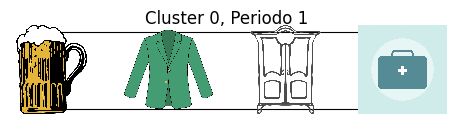

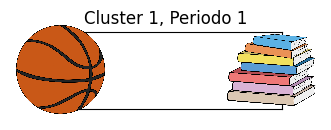

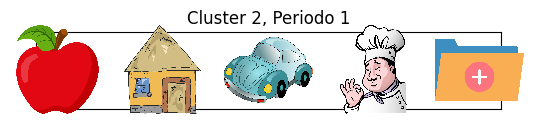

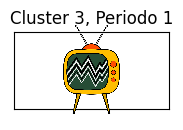

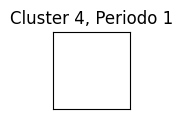

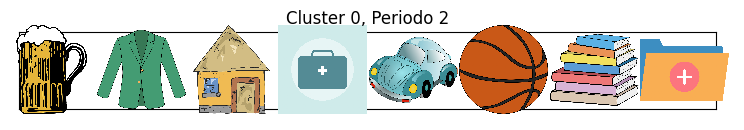

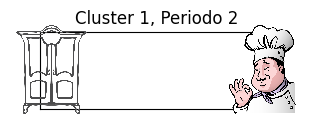

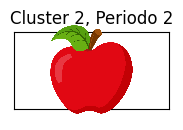

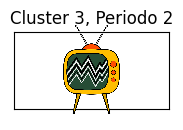

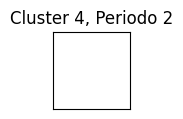

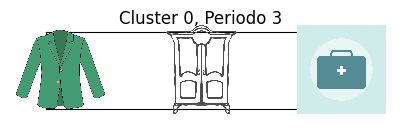

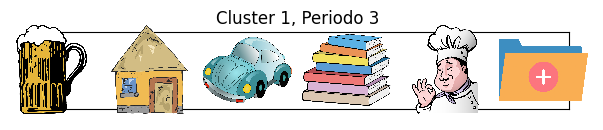

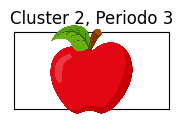

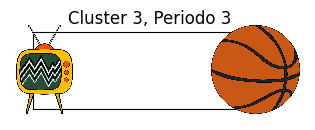

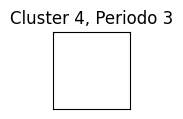

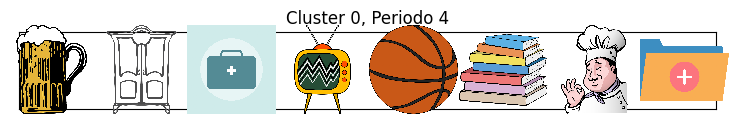

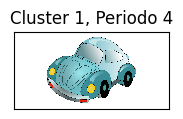

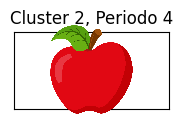

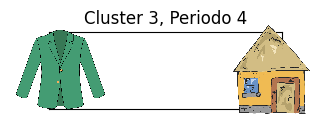

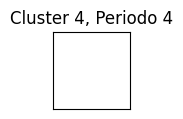

In [91]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

d = conglomerados_evolucion.to_dict('index')
ecoicop_grupos = [x for x,y in d.items()]
# vamos a declarar las imagenes que queremos que aparezcan en los nodos
labeldict = {}
labeldict[ecoicop_grupos[0]] = ['apple.png',i1]
labeldict[ecoicop_grupos[1]] = ['beer.png',i2]
labeldict[ecoicop_grupos[2]] = ['chaqueta.png',i3]
labeldict[ecoicop_grupos[3]] = ['house.png',i4]
labeldict[ecoicop_grupos[4]] = ['closet.png',i5]
labeldict[ecoicop_grupos[5]] = ['medical.png',i6]
labeldict[ecoicop_grupos[6]] = ['car.png',i7]
labeldict[ecoicop_grupos[7]] = ['antena.png',i8]
labeldict[ecoicop_grupos[8]] = ['basketball.png',i9]
labeldict[ecoicop_grupos[9]] = ['books.png',i10]
labeldict[ecoicop_grupos[10]] = ['chef.png',i11]
labeldict[ecoicop_grupos[11]] = ['suma.png',i12]

for p,per,fichero in [(1,'Periodo1','Periodo1.png'),(2,'Periodo2','Periodo2.png'),(3,'Periodo3','Periodo3.png'),(4,'Periodo4','Periodo4.png')]:
  d2 = {}
  for k in d.keys():
    d2[k] = [d[k][per]] # accedemos al cluster de la observación k en el periodo per
  df = pd.DataFrame(d2).transpose()
  for s in range(nclusters):
    cluster = df.loc[df.iloc[:,0] == s]
    # print(cluster[0].drop_duplicates())
    # print(len(cluster[0]))
    G = nx.Graph() # Create a graph

    # Add nodes
    c = 0
    for node in range(len(cluster[0])):
      name = 'image'+str(c)
      G.add_node(name, pos=(c,0))
      c += 1

    # Add edges
    # for node in range(len(cluster[0])-1):
    #   node1 = 'image'+str(node)
    #   node2 = 'image'+str(node+1)
    #   G.add_edge(node1, node2)
    # if len(cluster[0]) > 1: G.add_edge('image'+str(node+1),'image0')
    
    
    # Create a figure
    fig, ax = plt.subplots(figsize=(len(cluster[0])+1, 1))

    # Add the nodes and edges to the plot
    pos = nx.get_node_attributes(G, 'pos')
    # print(pos)
    nx.draw_networkx_nodes(G, pos, node_shape='s', node_size=2000, node_color='white', ax=ax)
    nx.draw_networkx_edges(G, pos, width=2, edge_color='gray', ax=ax)

    # Add images to the nodes
    image_files = []
    for t in [im for im in cluster.index]:
      # print(labeldict[t][0])
      image_files.append(labeldict[t][0])
    # print(image_files)
    for i, node in enumerate(G.nodes()):
        image = plt.imread(image_files[i])
        imagebox = OffsetImage(image, zoom=0.05)
        ab = AnnotationBbox(imagebox, pos[node], frameon=False)
        ax.add_artist(ab)

    # Remove the axis ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Adding a title
    ax.set_title('Cluster '+str(s)+', Periodo '+str(p))

    # Saving the plots 
    fich = 'cluster'+str(s)+'_'+fichero
    plt.savefig(fich, bbox_inches='tight')






In [92]:
from PIL import Image
i01 = Image.open("/content/cluster0_Periodo1.png")
i02 = Image.open("/content/cluster0_Periodo2.png")
i03 = Image.open("/content/cluster0_Periodo3.png")
i04 = Image.open("/content/cluster0_Periodo4.png")

i11 = Image.open("/content/cluster1_Periodo1.png")
i12 = Image.open("/content/cluster1_Periodo2.png")
i13 = Image.open("/content/cluster1_Periodo3.png")
i14 = Image.open("/content/cluster1_Periodo4.png")

i21 = Image.open("/content/cluster2_Periodo1.png")
i22 = Image.open("/content/cluster2_Periodo2.png")
i23 = Image.open("/content/cluster2_Periodo3.png")
i24 = Image.open("/content/cluster2_Periodo4.png")

i31 = Image.open("/content/cluster3_Periodo1.png")
i32 = Image.open("/content/cluster3_Periodo2.png")
i33 = Image.open("/content/cluster3_Periodo3.png")
i34 = Image.open("/content/cluster3_Periodo4.png")

i41 = Image.open("/content/cluster4_Periodo1.png")
i42 = Image.open("/content/cluster4_Periodo2.png")
i43 = Image.open("/content/cluster4_Periodo3.png")
i44 = Image.open("/content/cluster4_Periodo4.png")



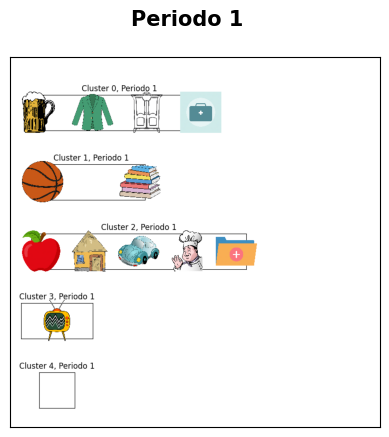

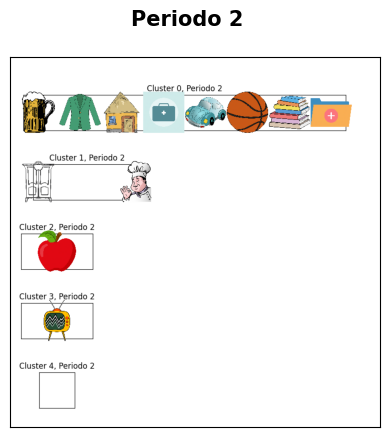

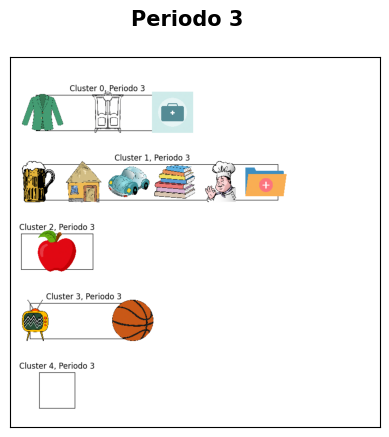

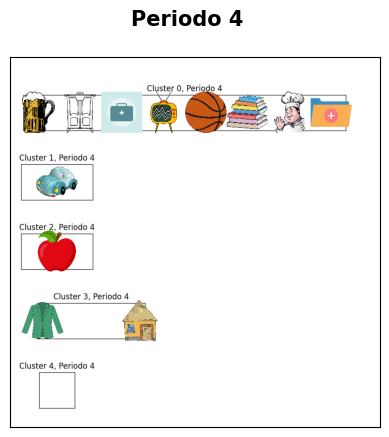

In [93]:
width = 800  # Ancho de la imagen final
height = 800  # Alto de la imagen final

count = 1
for ims in [[i01,i11,i21,i31,i41],[i02,i12,i22,i32,i42],[i03,i13,i23,i33,i43],[i04,i14,i24,i34,i44]]:
  fich = 'Periodo'+str(count)+'.png'
  imagen_final = Image.new('RGB', (width, height), (255, 255, 255))  # Crear imagen blanca de fondo

  imagen_final.paste(ims[0], (10, 50))  # Pegar imagen 1 en la posición (50, 10)
  imagen_final.paste(ims[1], (10, 200))  # Pegar imagen 2 en la posición (200, 10)
  imagen_final.paste(ims[2], (10, 350))  # Pegar imagen 3 en la posición (350, 10)
  imagen_final.paste(ims[3], (10, 500))  # Pegar imagen 4 en la posición (500, 10)
  imagen_final.paste(ims[4], (10, 650))  # Pegar imagen 5 en la posición (650, 10)

  imagen_final.save('imagen_final.png')

  fig = plt.figure()
  fig.suptitle("Periodo "+str(count),size=15,weight='extra bold',stretch='extra-expanded')
  ax = fig.add_subplot(1,1,1)
  ax.imshow(imagen_final)
  ax.xaxis.set_ticks([])
  ax.yaxis.set_ticks([])
  plt.savefig(fich, bbox_inches='tight')
  count += 1

iP1 = Image.open("/content/Periodo1.png")
iP2 = Image.open("/content/Periodo2.png")
iP3 = Image.open("/content/Periodo3.png")
iP4 = Image.open("/content/Periodo4.png")

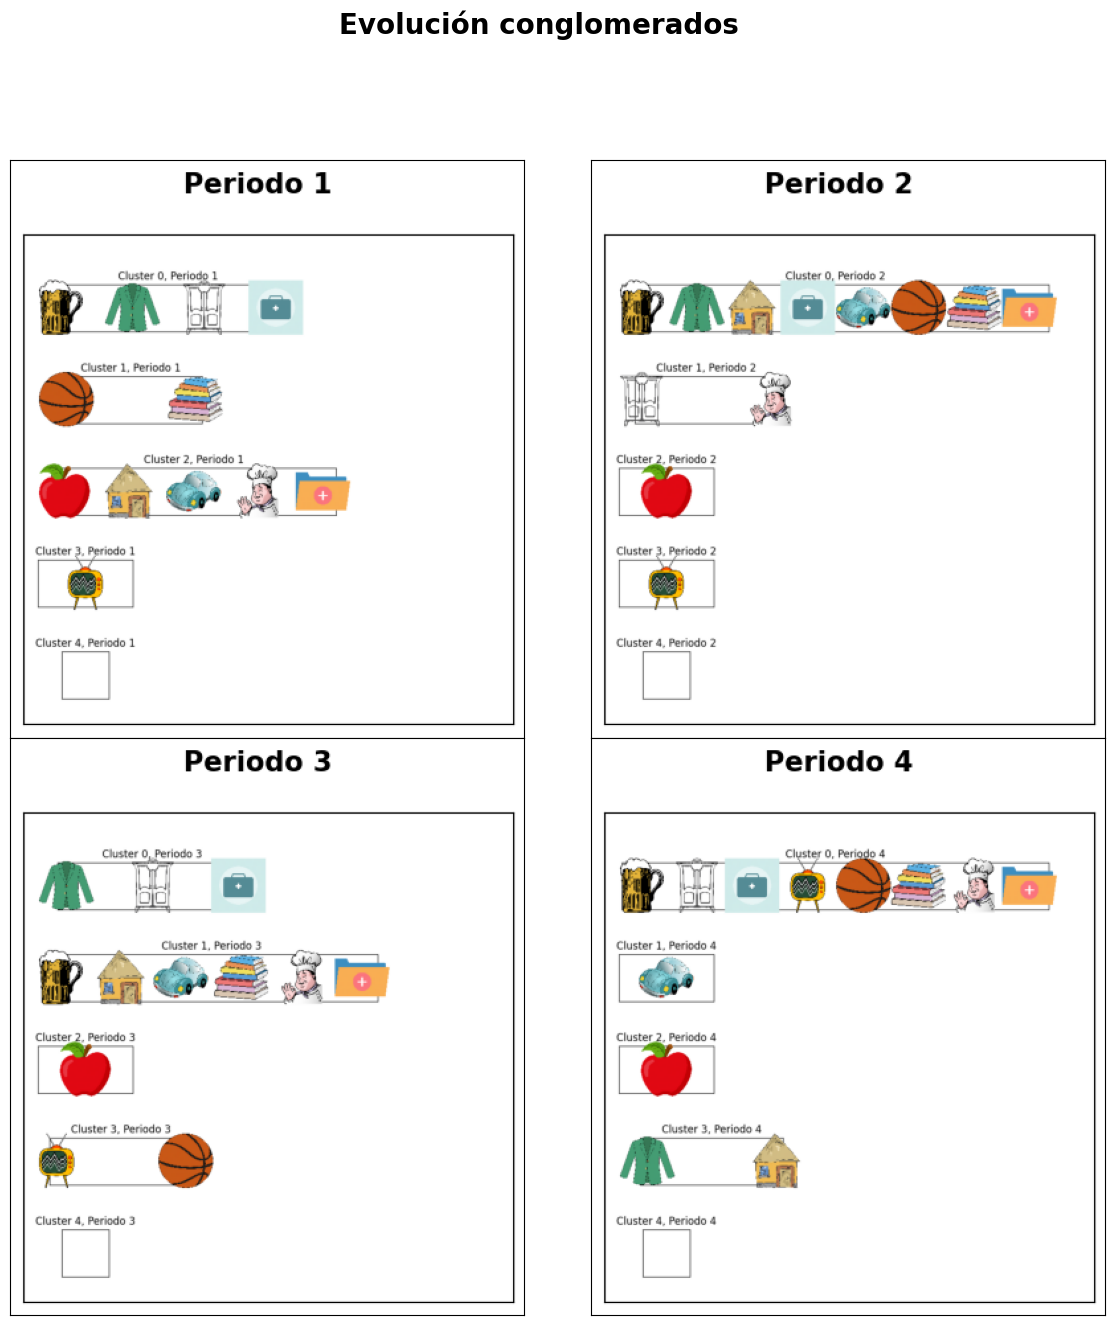

In [94]:
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle("Evolución conglomerados",fontsize=20,weight='extra bold',stretch='extra-expanded')
  
k = 1
for im in [iP1,iP2,iP3,iP4]:
    title = 'Periodo '+str(k)
    ax = fig.add_subplot(2,2,k)
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.imshow(im)
    k += 1

imagen = ax.get_figure()
ax.plot()
plt.savefig("Evolucion", bbox_inches='tight')

## Bondad de los resultados

## Conclusiones

También es interesante ver las series temporales por conglomerado y periodo para entender mejor cuál ha sido el proceso de unión de las series.

In [95]:
# Se crea un array que contenga los nombres de las comunidades autónomas para que sea más sencillo acceder a ellas.
ECOICOPdf = np.array(ECOICOP)
conglomerados1['Codigo'] = range(0,len(ECOICOP))

In [96]:
from IPython.display import Image

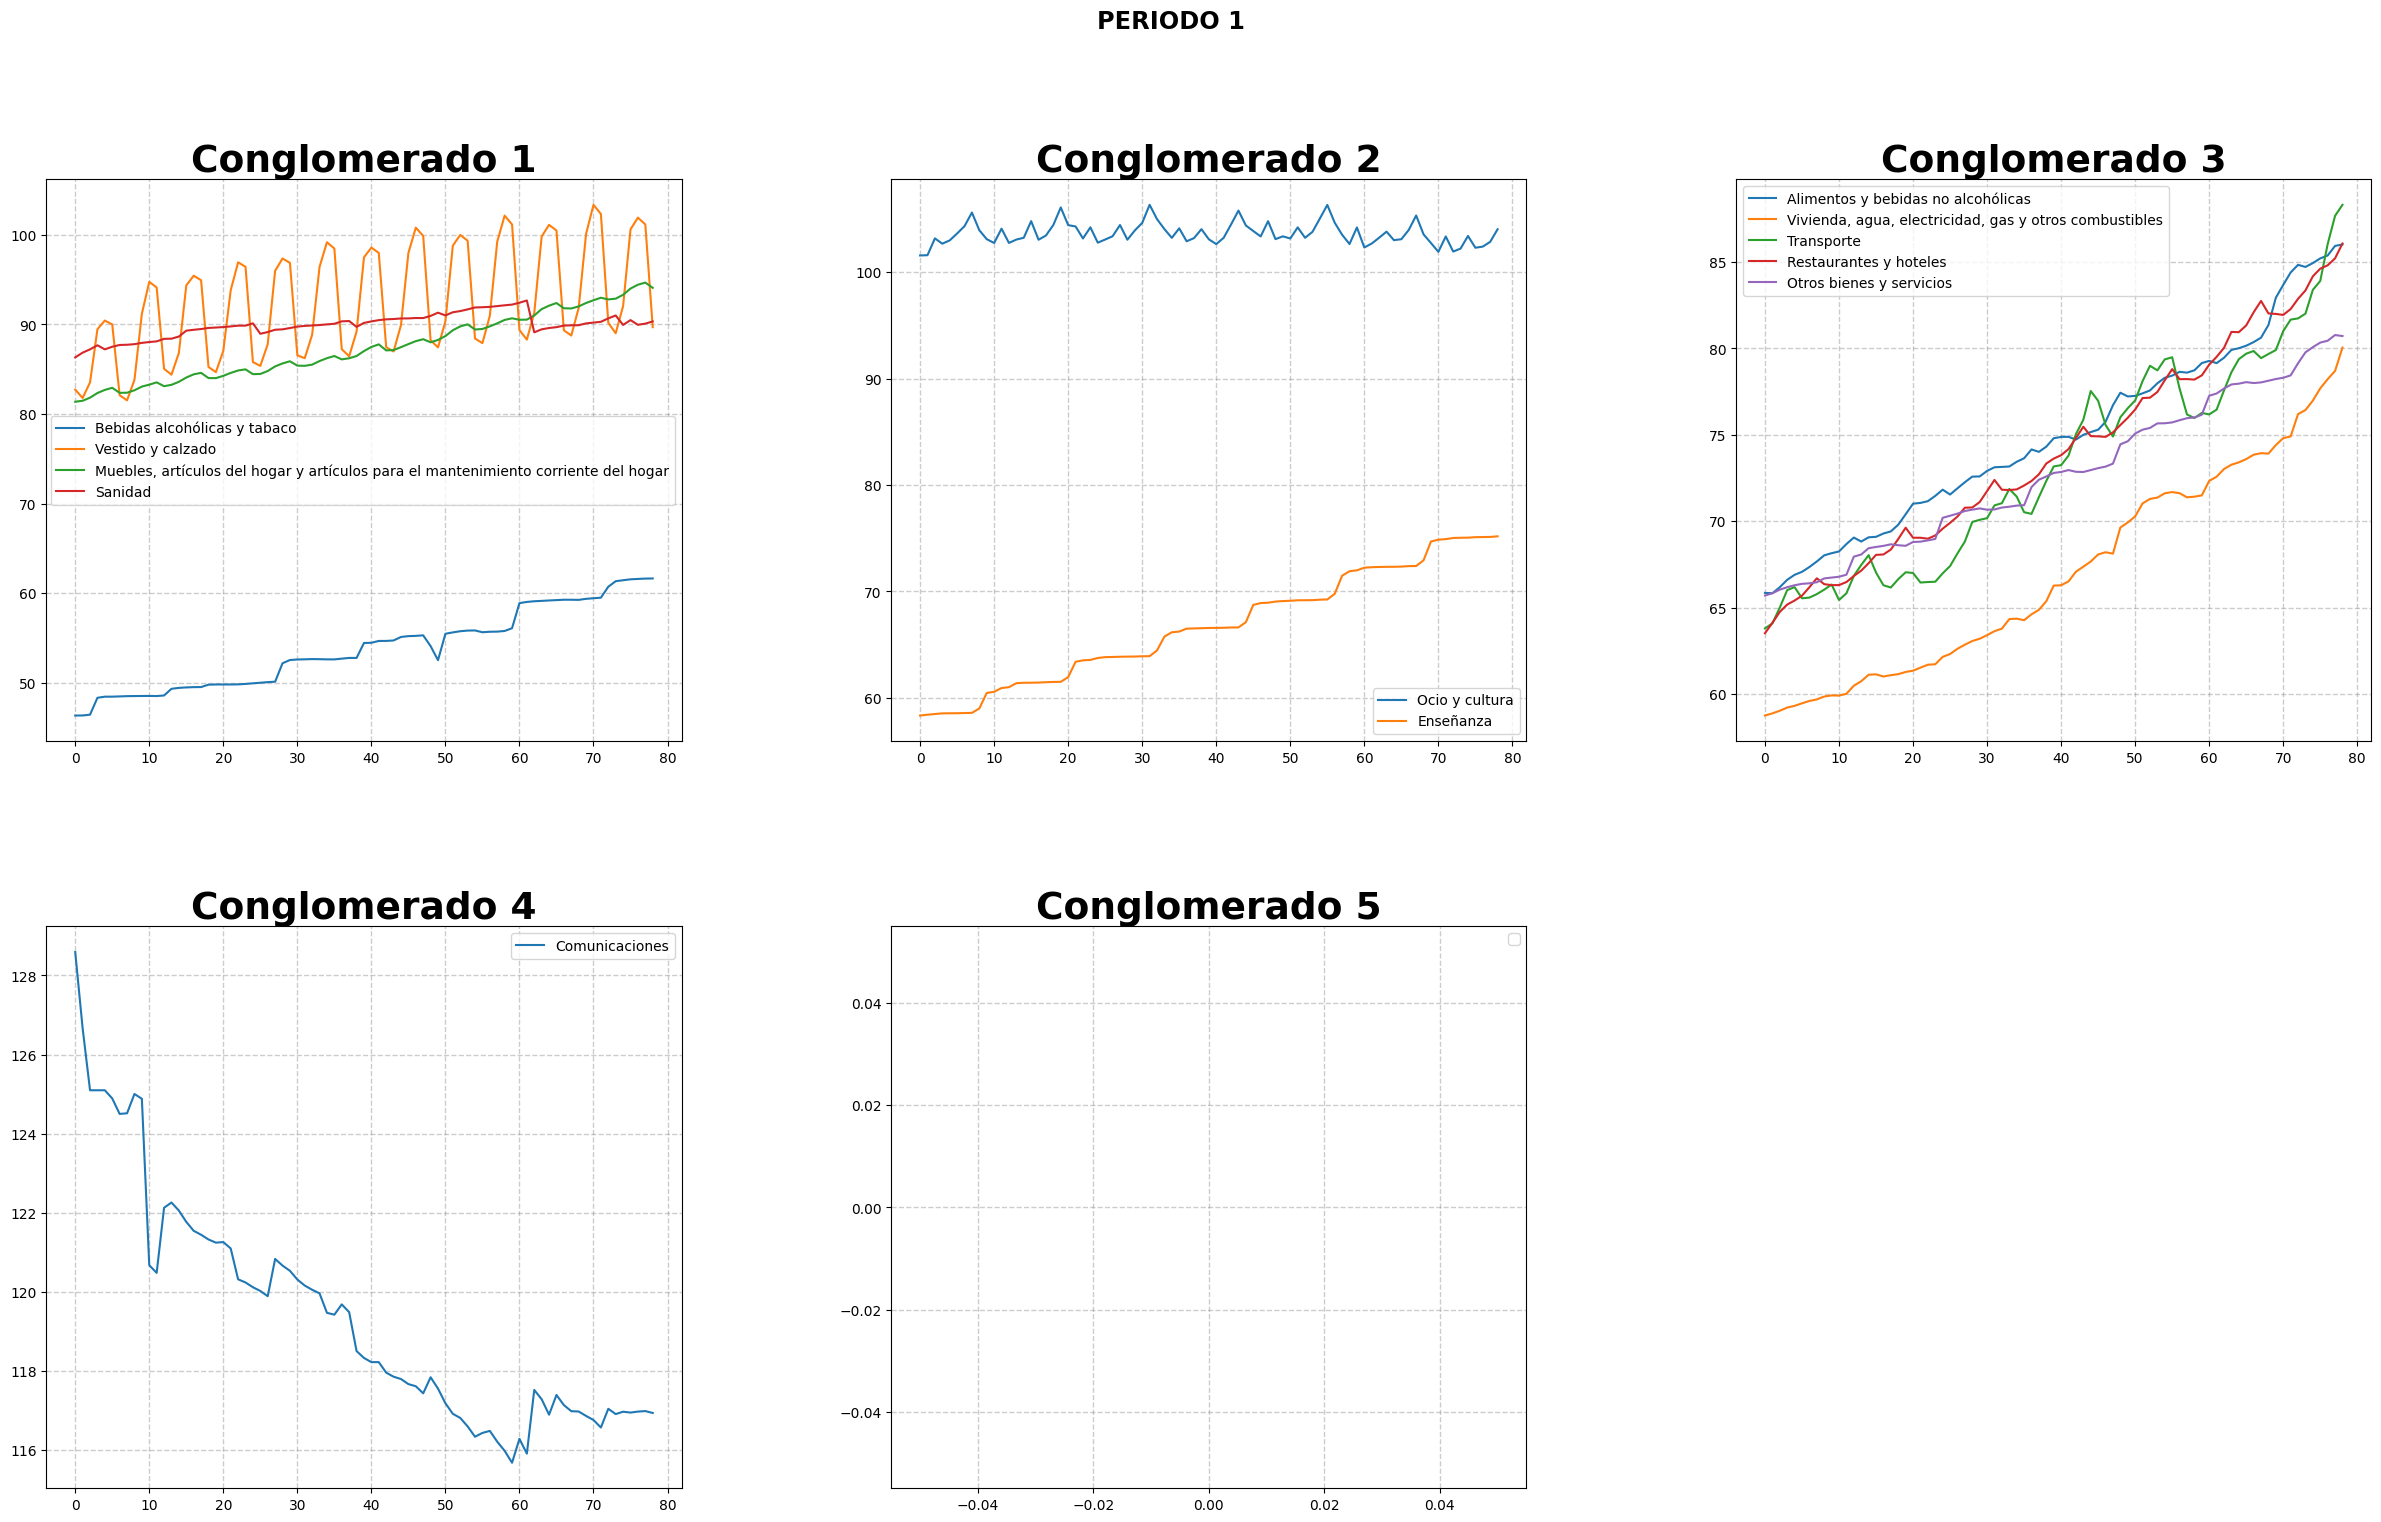

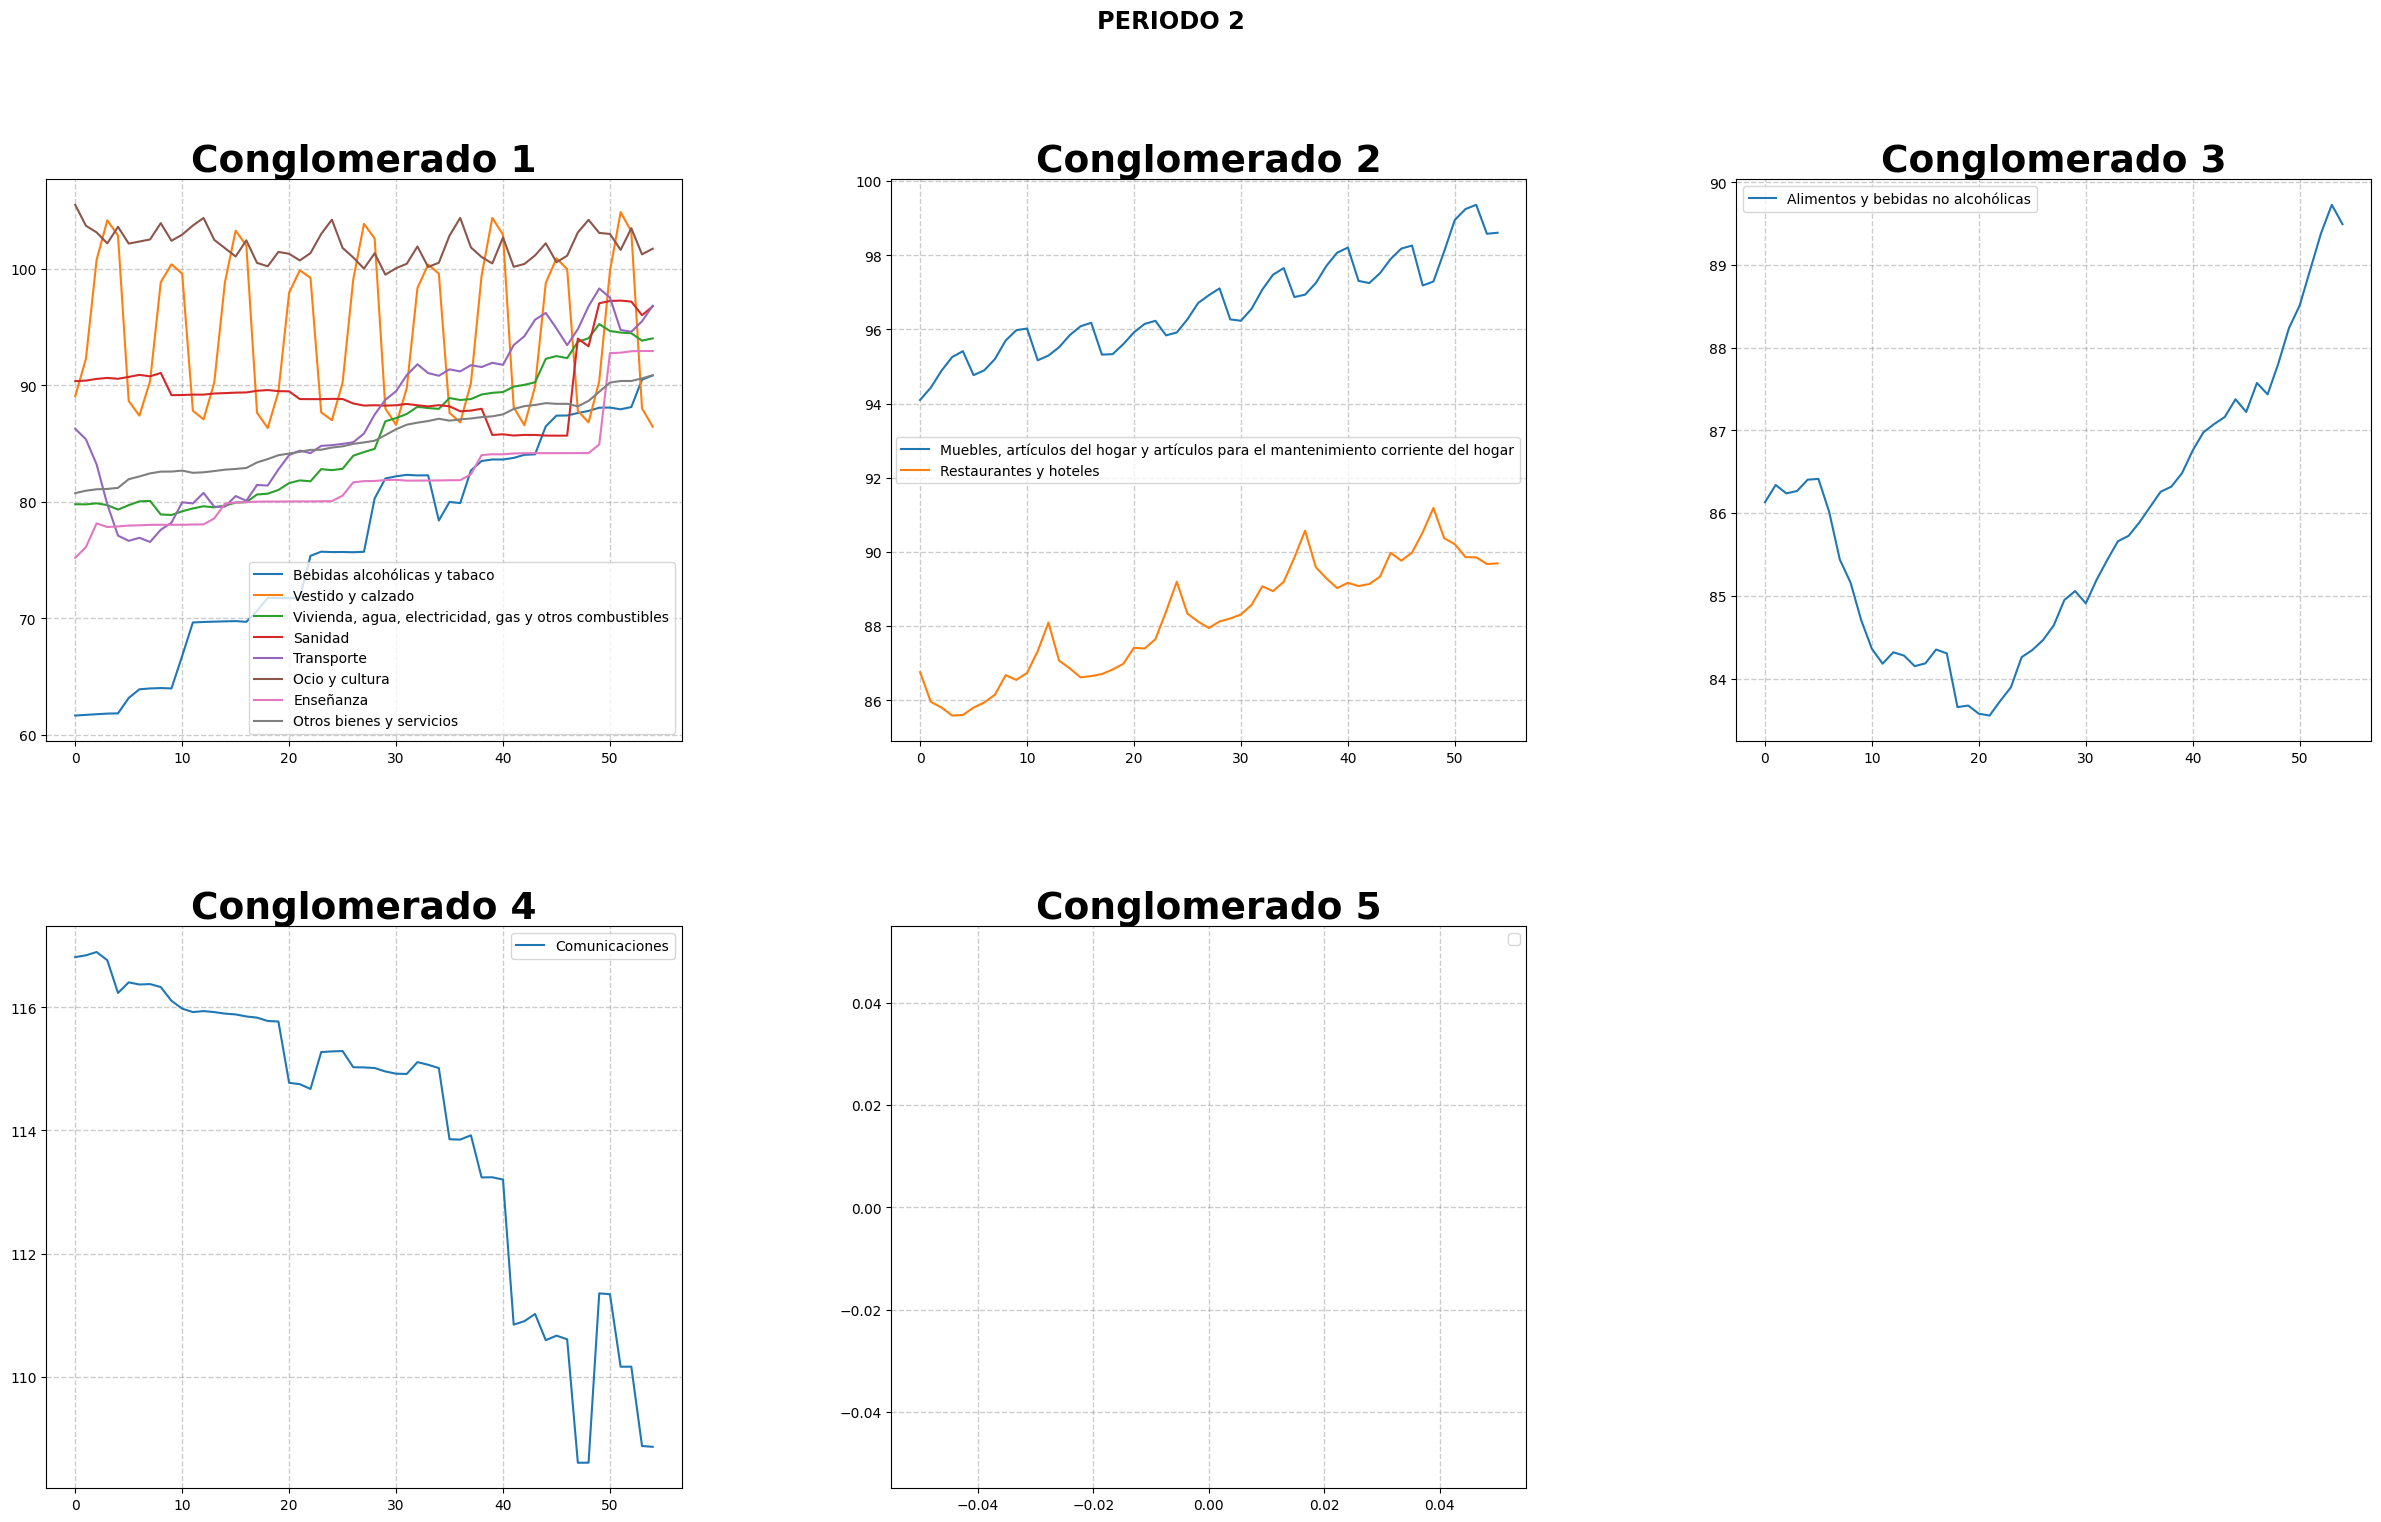

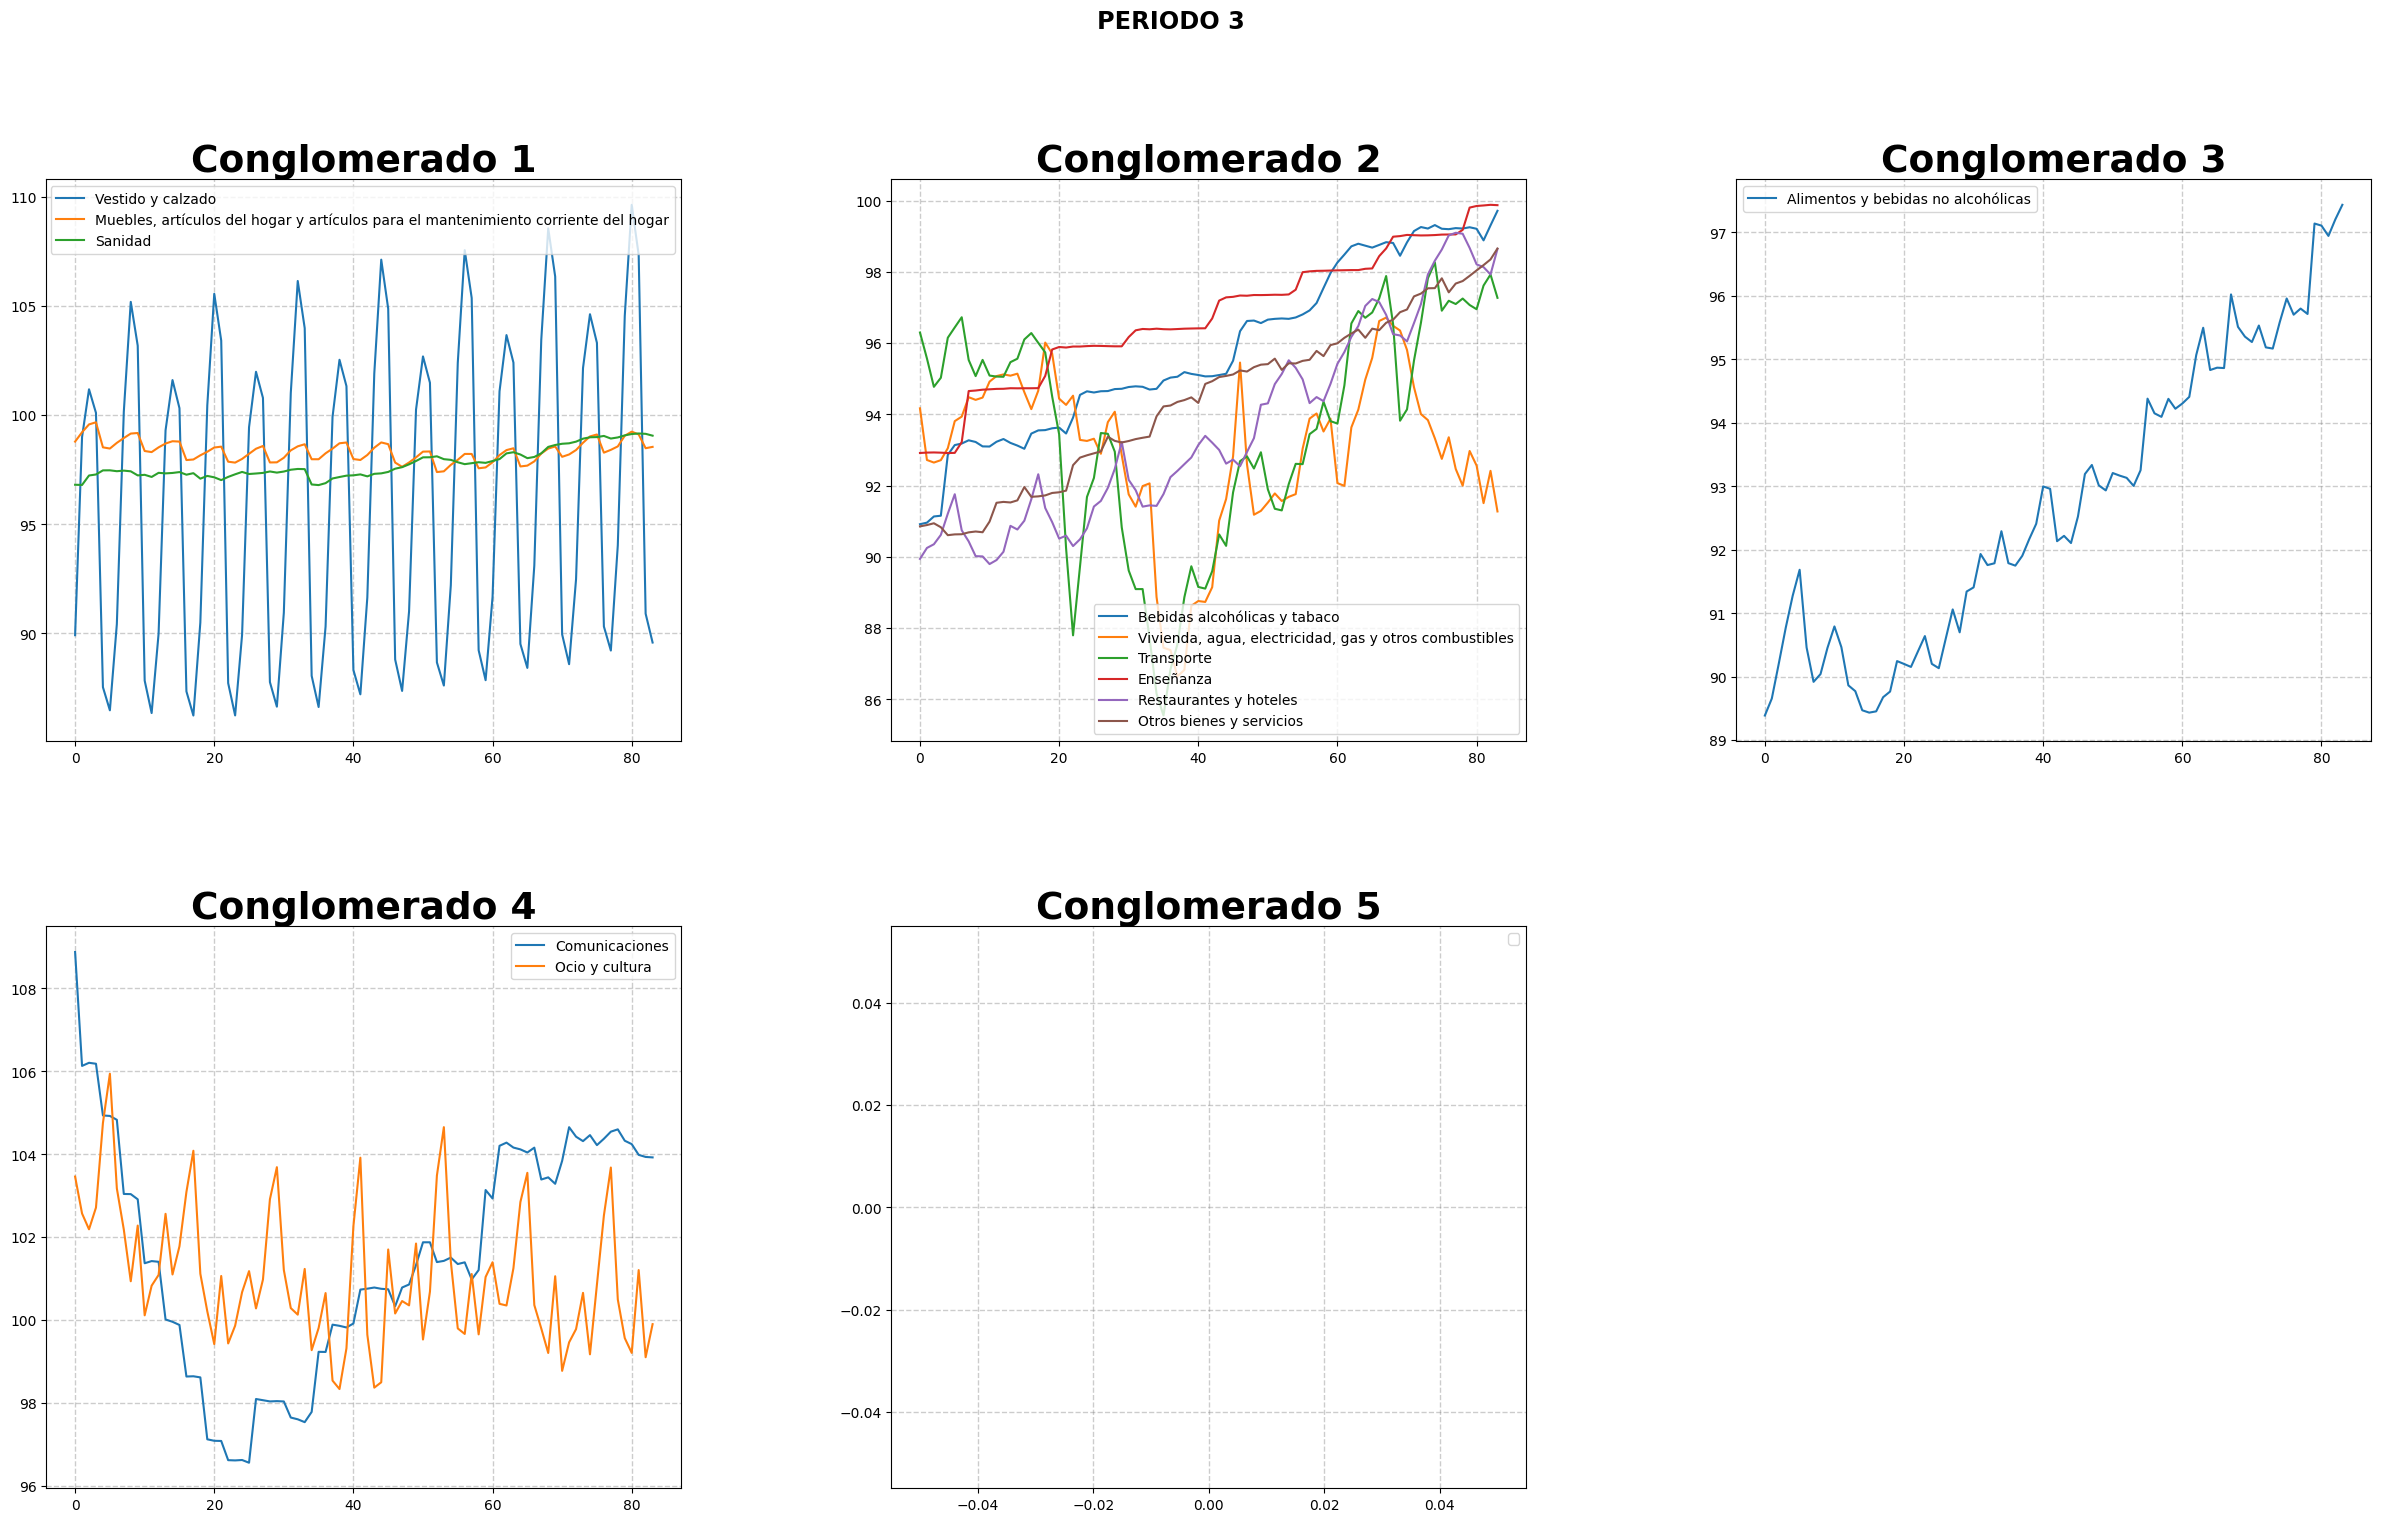

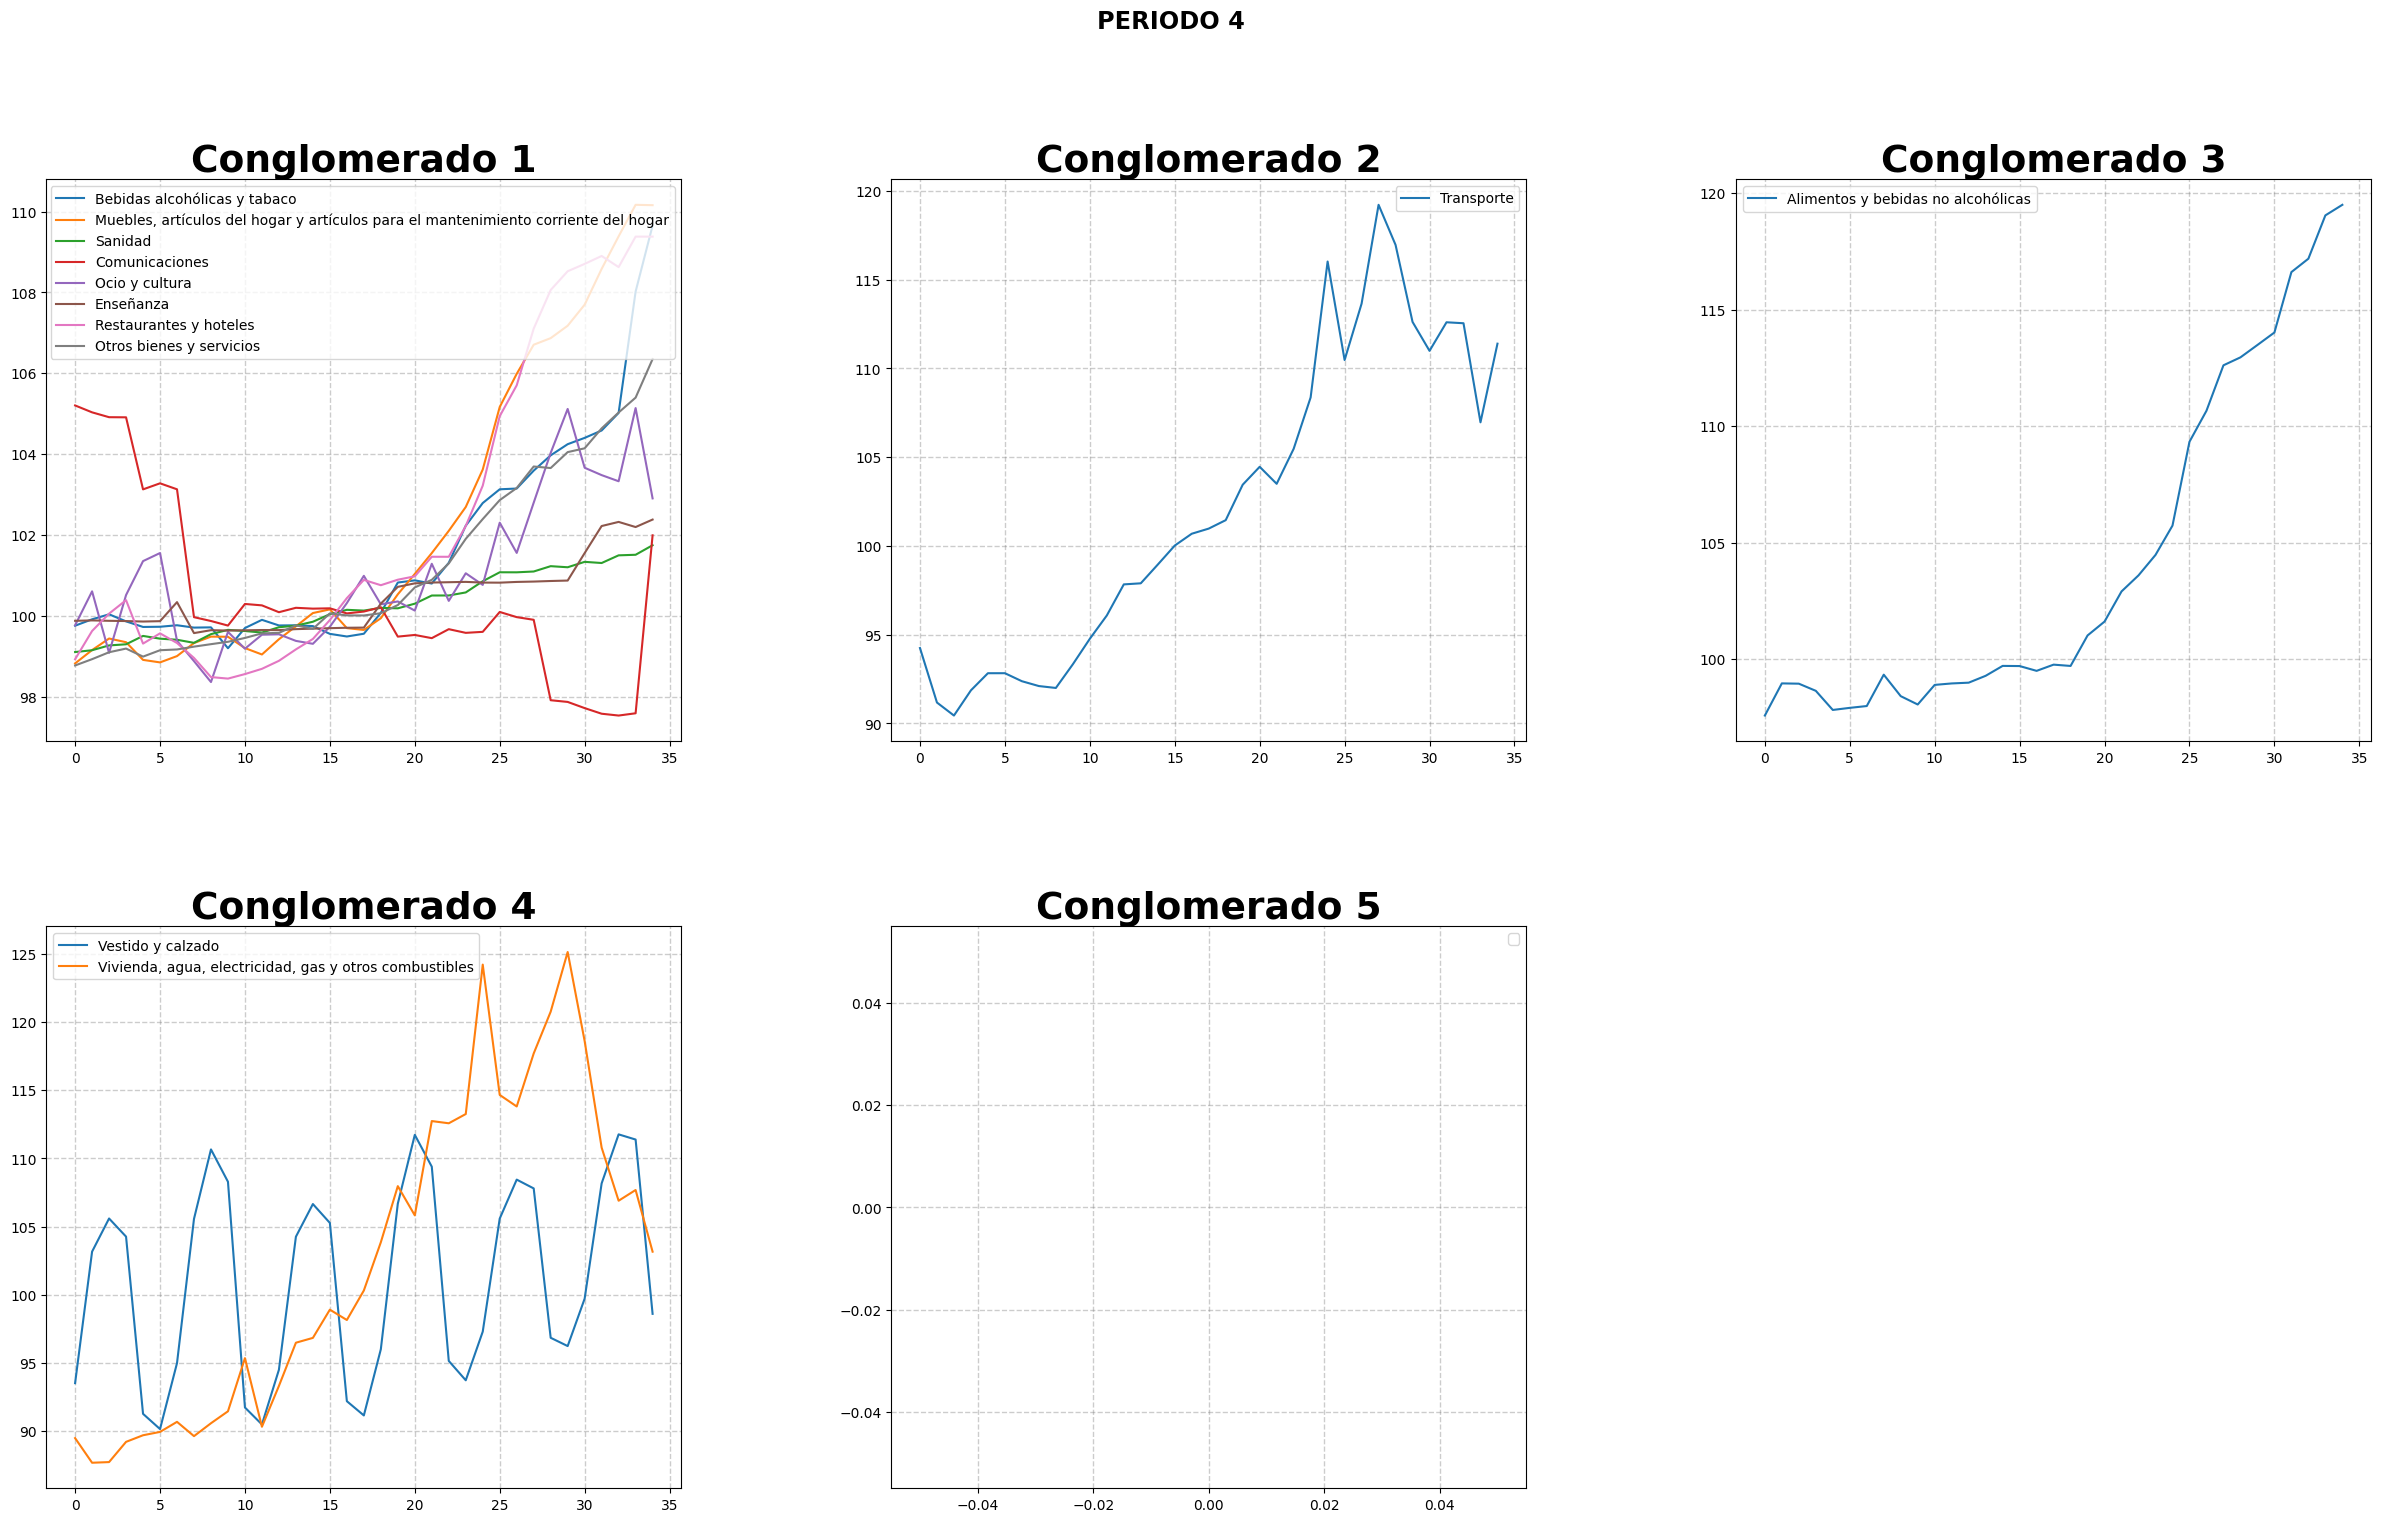

In [100]:
p = 1

for datos,cluster,name in [[datos_P1,conglomerados1,'Conglomerado1'],[datos_P2,conglomerados2,'Conglomerado2'],[datos_P3,conglomerados3,'Conglomerado3'],[datos_P4,conglomerados4,'Conglomerado4']]:

  k = 1
  fichero = 'ConglomeradosP'+str(p)

  subtitulo = 'PERIODO ' + str(p)
  fig = plt.figure(figsize=(30,17))
  fig.subplots_adjust(hspace=0.33, wspace=0.33)
  fig.suptitle(subtitulo,size='xx-large',weight='extra bold',stretch='extra-expanded')
  
  for c in range(n_states):
    title = 'Conglomerado '+str(c+1)
    idx = [i for i in range(cluster.shape[0]) if cluster[name][i] == c]
    ccaa0 = cluster[name][idx]
    ax = fig.add_subplot(2,3,k)
    x = range(0,datos.shape[0])
    ax.plot(x,datos[datos.columns[idx]])
    ax.legend(ECOICOPdf[idx])
    ax.grid(color='gray', linestyle='dashed', linewidth=1, alpha=0.4)
    ax.set_title(title,size='large',weight='extra bold',stretch='extra-expanded',fontsize=27)

    k += 1

  p += 1

  imagen = ax.get_figure()
  ax.plot()
  plt.savefig(fichero, bbox_inches='tight')

  plt.show() 
  

In [ ]:
# Es necesario descargar una librería para exportar este cuaderno a PDF.
!pip install nbconvert